In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import normalize
import datetime as dt
from pandas.tseries.offsets import MonthBegin
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

# A Glance at the Dataset

In [2]:
# Read the dataset
df = pd.read_excel('/Users/yuegao/Desktop/CanadPostCaseStudy/CaseStudy2022Data_20221102.xlsx')

In [3]:
# Check the first 5 rows
df.head()

Customer     City       Date  Volume
0  Customer #15  City #2 2021-12-22     402
1  Customer #11  City #2 2022-09-03     140
2  Customer #16  City #1 2022-03-04     913
3  Customer #10  City #1 2020-06-16    2580
4   Customer #2  City #2 2020-06-28       1

In [4]:
# Check the last 5 rows
df.shape

(22368, 4)

In [5]:
# Check the numerical features distribution
df.describe()

Volume
count  22368.000000
mean    1067.399991
std     1699.131661
min        1.000000
25%       19.000000
50%      470.000000
75%     1332.250000
max    17808.000000

In [6]:
# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22368 entries, 0 to 22367
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Customer  22368 non-null  object        
 1   City      22368 non-null  object        
 2   Date      22368 non-null  datetime64[ns]
 3   Volume    22368 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 699.1+ KB


In [7]:
# Check the total unique values of City
df['City'].unique()

array(['City #2', 'City #1'], dtype=object)

In [8]:
# Check the minimum and maximum date
df['Date'].min(),df['Date'].max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2022-10-28 00:00:00'))

# Data Cleaning

In [9]:
df.isnull().sum()

Customer    0
City        0
Date        0
Volume      0
dtype: int64

In [10]:
df[df['City'] == 'City #2']['Customer'].unique()

array(['Customer #15', 'Customer #11', 'Customer #2', 'Customer #16',
       'Customer #12', 'Customer #4', 'Customer #13', 'Customer #6',
       'Customer #10', 'Customer #14', 'Customer #5', 'Customer #7',
       'Customer #1', 'Customer #3'], dtype=object)

In [11]:
df[df['City'] == 'City #1']['Customer'].unique()

array(['Customer #16', 'Customer #10', 'Customer #4', 'Customer #5',
       'Customer #11', 'Customer #12', 'Customer #6', 'Customer #7',
       'Customer #2', 'Customer #13', 'Customer #1', 'Customer #15',
       'Customer #14', 'Customer #3'], dtype=object)

In [12]:
df['City'] = df['City'].str.replace(' #','')

In [13]:
df['Customer'] = df['Customer'].str.replace(' #','')

# Exploratory Data Analysis

## Univariate Analysis

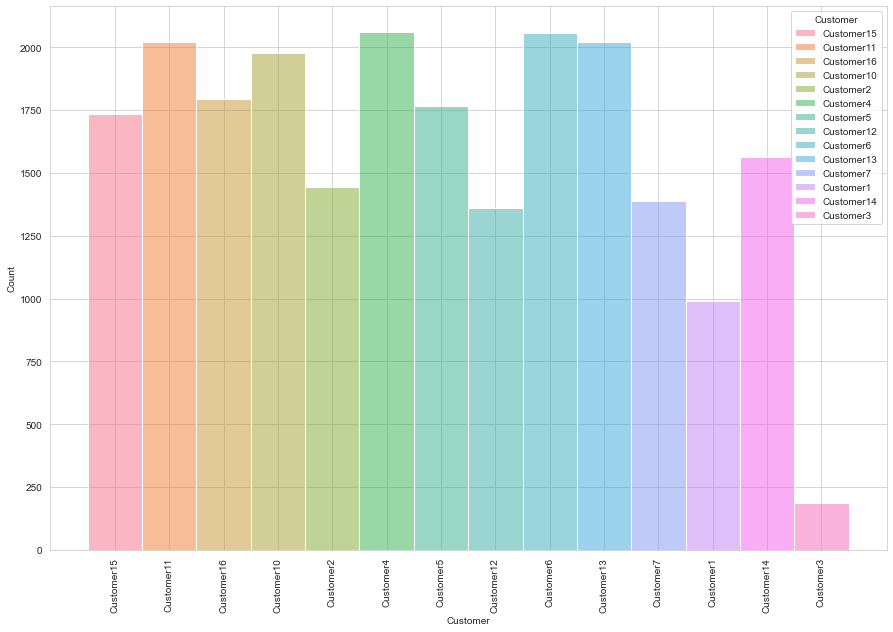

In [14]:
plt.figure(figsize=(15,10))
sns.histplot(x = 'Customer', data = df, hue = 'Customer')
plt.xticks(rotation = 90)
plt.show()

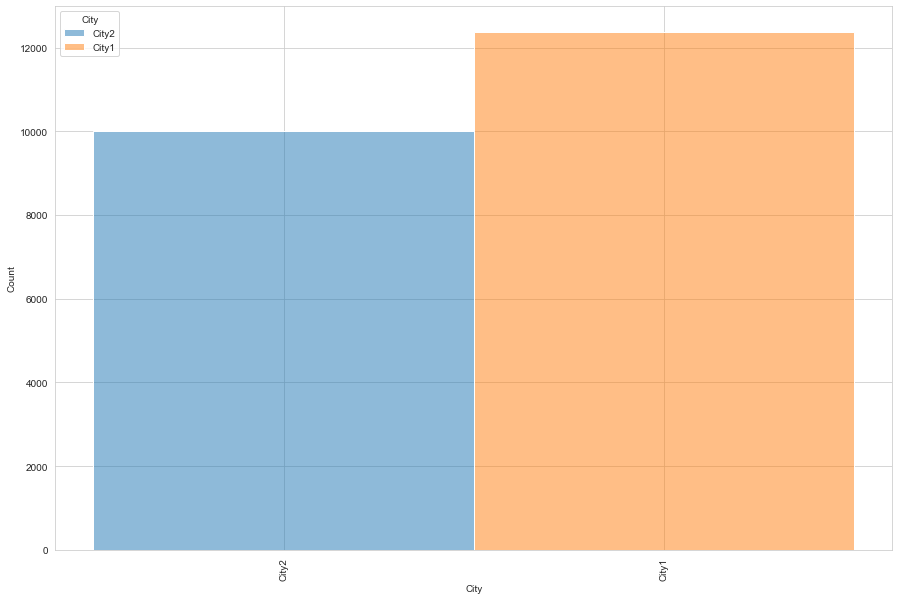

In [15]:
plt.figure(figsize=(15,10))
sns.histplot(x = 'City', data = df, hue = 'City')
plt.xticks(rotation = 90)
plt.show()

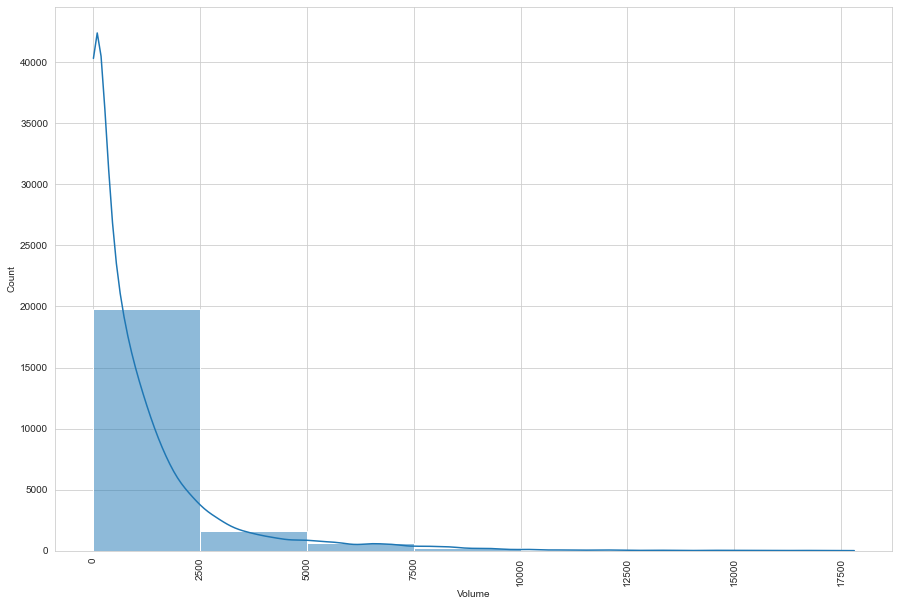

In [16]:
plt.figure(figsize=(15,10))
sns.histplot(data = df, x = 'Volume', kde = True, 
             bins= np.arange(0,20000,2500))
plt.xticks(rotation = 90)
plt.show()

## Multivariate Analysis

In [17]:
initial_cvd = df[(df['Date']>=dt.datetime(2020,4,1))&(df['Date']<=dt.datetime(2020,6,30))].sort_values('Date',ascending= True)
additional_cvd = df[(df['Date']>=dt.datetime(2021,4,1))&(df['Date']<=dt.datetime(2021,6,15))].sort_values('Date',ascending= True)
campaign = df[(df['Date']>=dt.datetime(2022,9,1))].sort_values('Date',ascending= True)


### City, Volume

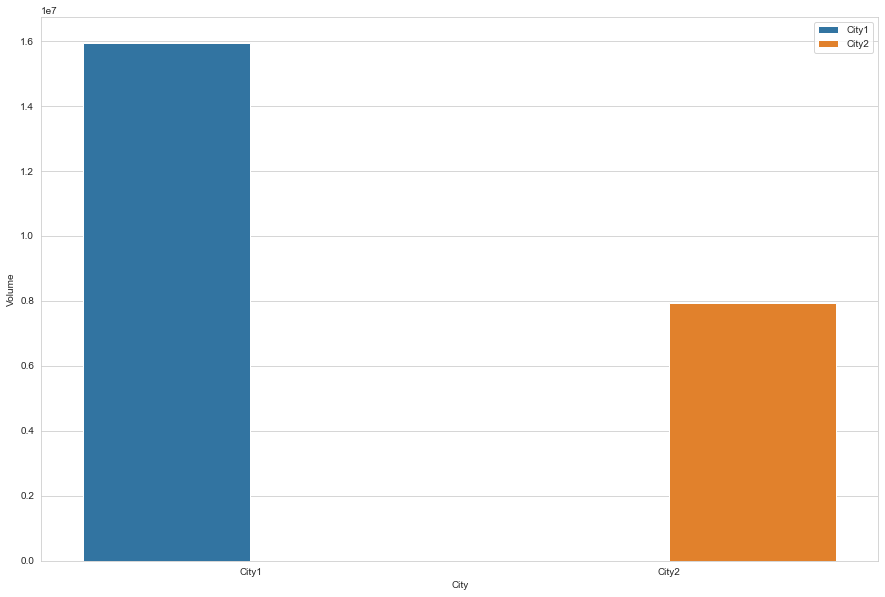

In [18]:
plt.figure(figsize=(15,10))
sns.barplot(data = df.groupby(['City']).sum('Volume').reset_index(), x = 'City', y = 'Volume', hue = 'City')
plt.legend()
plt.show()

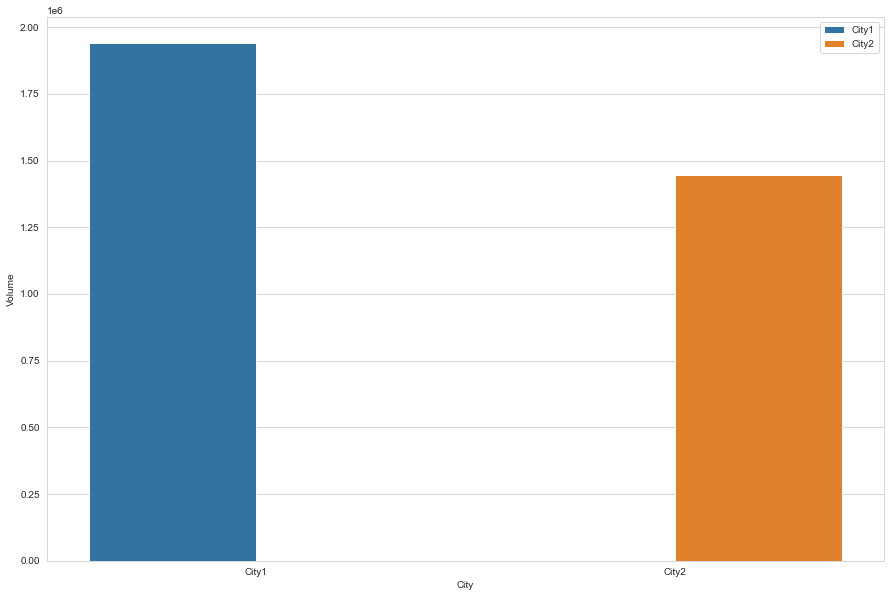

In [19]:
plt.figure(figsize=(15,10))
sns.barplot(data = initial_cvd.groupby(['City']).sum('Volume').reset_index(), x = 'City', y = 'Volume', hue = 'City')
plt.legend()
plt.show()

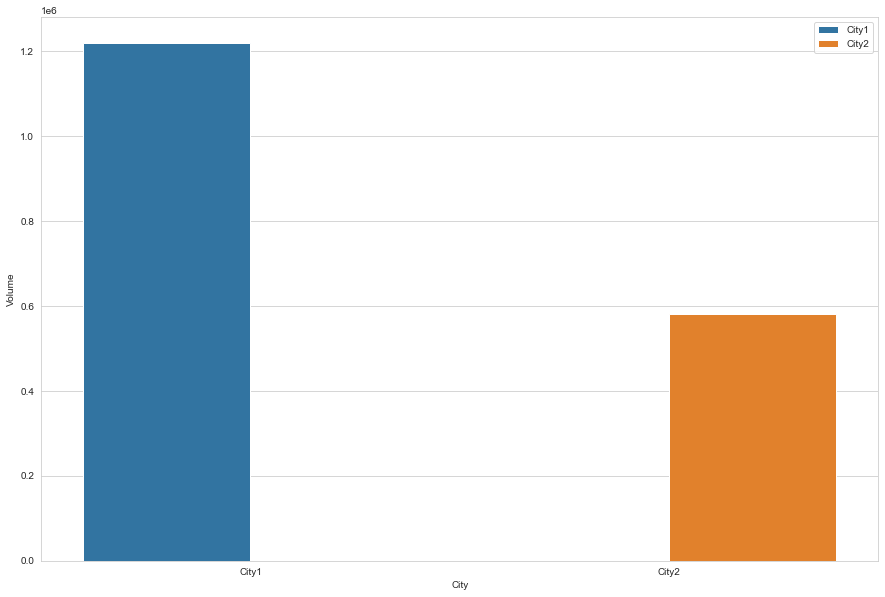

In [20]:
plt.figure(figsize=(15,10))
sns.barplot(data = additional_cvd.groupby(['City']).sum('Volume').reset_index(), x = 'City', y = 'Volume', hue = 'City')
plt.legend()
plt.show()

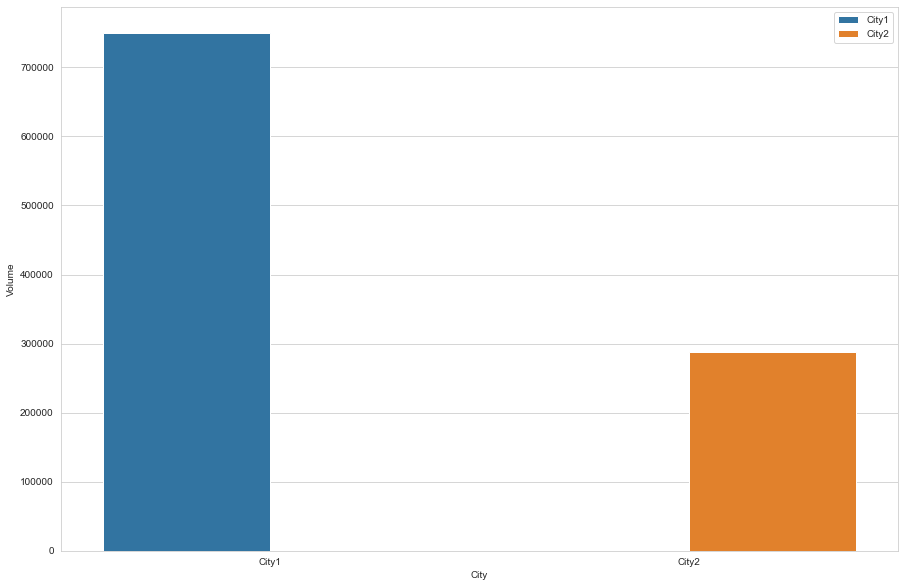

In [21]:
plt.figure(figsize=(15,10))
sns.barplot(data = campaign.groupby(['City']).sum('Volume').reset_index(), x = 'City', y = 'Volume', hue = 'City')
plt.legend()
plt.show()

### Date, City, Volume

In [22]:
gb_date_city_df = df.groupby(['Date','City']).sum('Volume').reset_index()

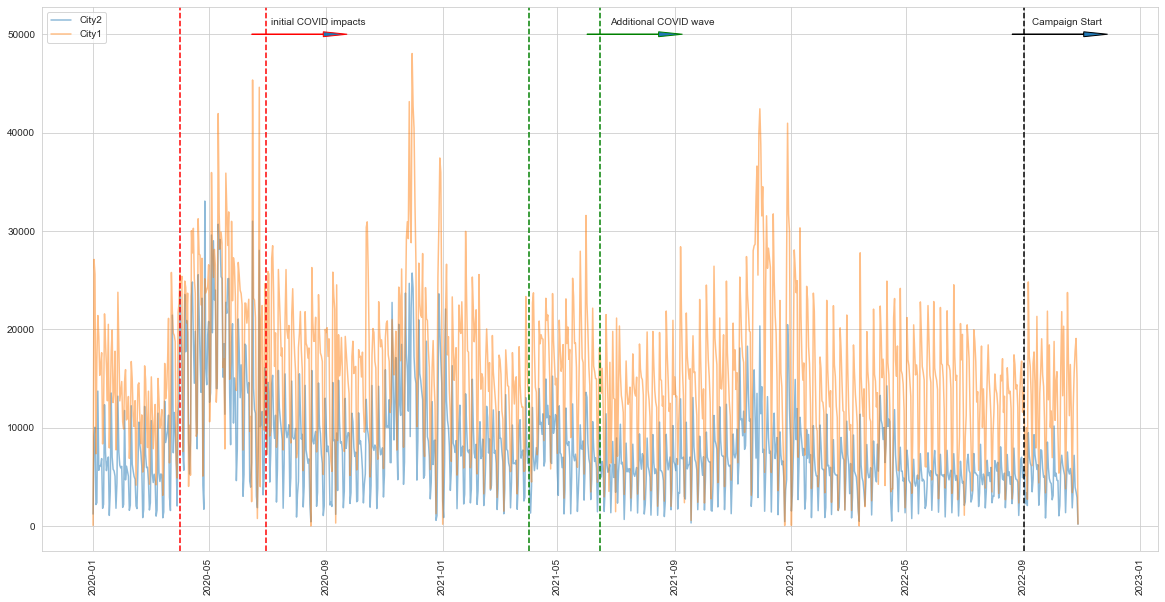

In [23]:
plt.figure(figsize=(20,10))
plt.plot(gb_date_city_df[gb_date_city_df['City']=='City2']['Date'],
         gb_date_city_df[gb_date_city_df['City']=='City2']['Volume'],alpha = 0.5, label = 'City2')
plt.plot(gb_date_city_df[gb_date_city_df['City']=='City1']['Date'],
         gb_date_city_df[gb_date_city_df['City']=='City1']['Volume'], alpha = 0.5, label = 'City1')
plt.axvline(dt.datetime(2020, 4, 1), linestyle = '--',color = 'red')
plt.axvline(dt.datetime(2020, 6, 30), linestyle = '--',color = 'red')
plt.axvline(dt.datetime(2021, 4, 1), linestyle = '--',color = 'green')
plt.axvline(dt.datetime(2021, 6, 15), linestyle = '--',color = 'green')
plt.axvline(dt.datetime(2022, 9, 1), linestyle = '--',color = 'black')
plt.arrow(dt.datetime(2020, 6, 15), 50000,100,0,length_includes_head=True,
          width = 10,
          head_width = 500,
          head_length = 25,
          ec ='red')
plt.text(dt.datetime(2020, 7, 5),51000,'initial COVID impacts')
plt.arrow(dt.datetime(2021, 6, 1), 50000,100,0,length_includes_head=True,
          width = 10,
          head_width = 500,
          head_length = 25,
          ec ='green')
plt.text(dt.datetime(2021, 6, 25),51000,'Additional COVID wave')
plt.arrow(dt.datetime(2022, 8, 20), 50000,100,0,length_includes_head=True,
          width = 10,
          head_width = 500,
          head_length = 25,
          ec ='black')
plt.text(dt.datetime(2022, 9, 10),51000,'Campaign Start')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

#### Break down the time series data into several time periods

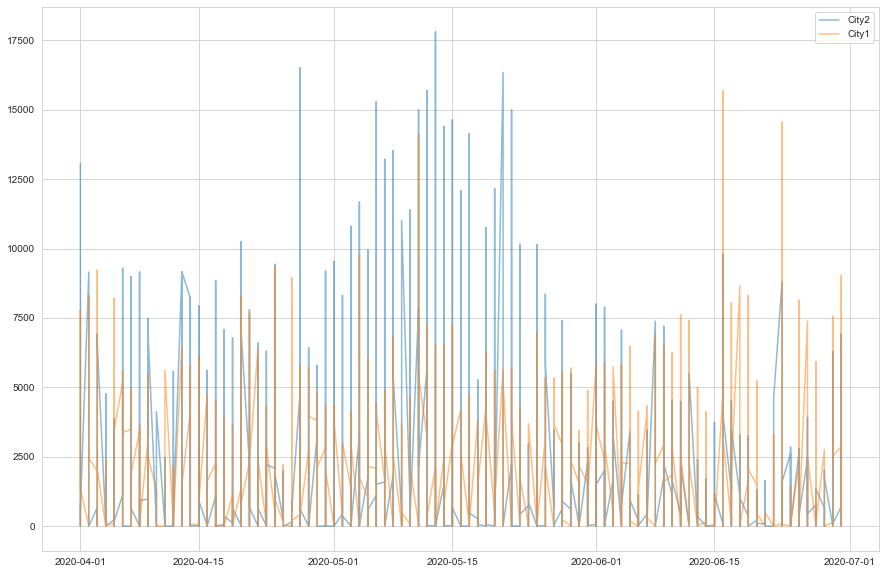

In [24]:
plt.figure(figsize = (15,10))
plt.plot(initial_cvd[initial_cvd['City'] == 'City2']['Date'],initial_cvd[initial_cvd['City'] == 'City2']['Volume'],alpha = 0.5, label = 'City2')

plt.plot(initial_cvd[initial_cvd['City'] == 'City1']['Date'],initial_cvd[initial_cvd['City'] == 'City1']['Volume'],alpha = 0.5, label = 'City1')
plt.legend()
plt.show()

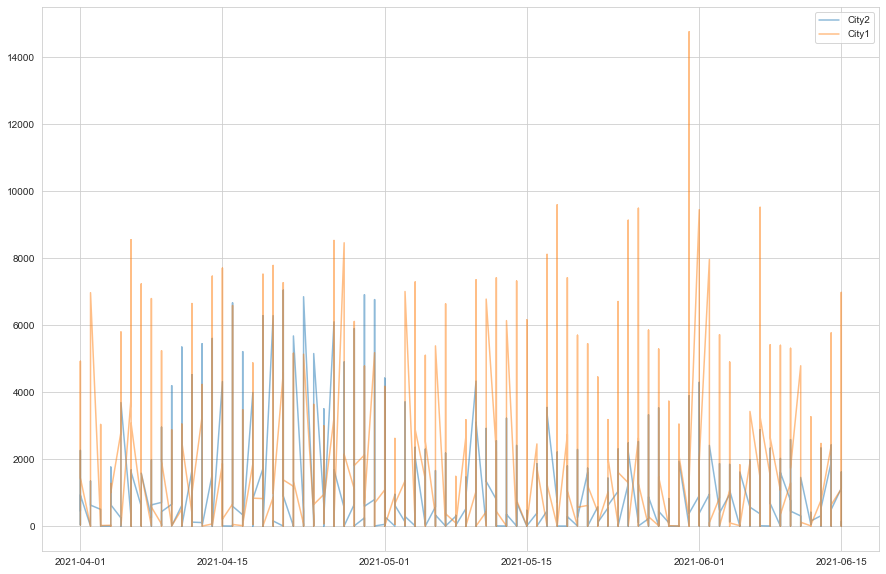

In [25]:
plt.figure(figsize = (15,10))
plt.plot(additional_cvd[additional_cvd['City'] == 'City2']['Date'],additional_cvd[additional_cvd['City'] == 'City2']['Volume'],alpha = 0.5, label = 'City2')

plt.plot(additional_cvd[additional_cvd['City'] == 'City1']['Date'],additional_cvd[additional_cvd['City'] == 'City1']['Volume'],alpha = 0.5, label = 'City1')
plt.legend()
plt.show()

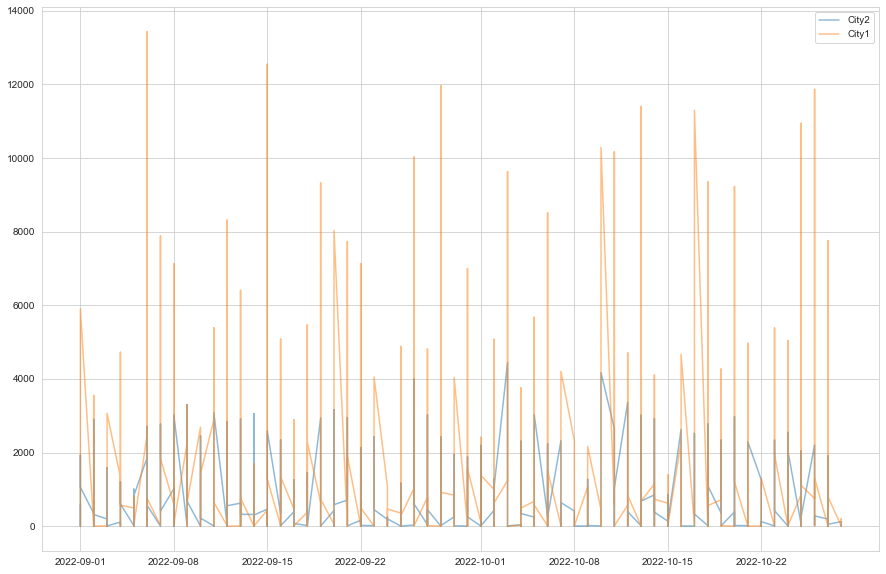

In [26]:
campaign = df[(df['Date']>=dt.datetime(2022,9,1))].sort_values('Date',ascending= True)
plt.figure(figsize = (15,10))
plt.plot(campaign[campaign['City'] == 'City2']['Date'],campaign[campaign['City'] == 'City2']['Volume'],alpha = 0.5, label = 'City2')

plt.plot(campaign[campaign['City'] == 'City1']['Date'],campaign[campaign['City'] == 'City1']['Volume'],alpha = 0.5, label = 'City1')
plt.legend()
plt.show()

### City, Customer, Volume

In [27]:
gb_city_customer_df = df.groupby(['City','Customer']).sum('Volume').reset_index()

In [28]:
gb_city_customer_df['Customer'] =gb_city_customer_df['Customer'].str.replace('Customer','').astype(int)

In [29]:
gb_city_customer_df = gb_city_customer_df.sort_values(['City','Customer'], ascending= [True,True])

In [30]:
gb_city_customer_df

City  Customer   Volume
0   City1         1   721027
8   City1         2  1742840
9   City1         3      672
10  City1         4  5641276
11  City1         5   541061
12  City1         6  1768931
13  City1         7  1013465
1   City1        10  1724978
2   City1        11  1074778
3   City1        12    28462
4   City1        13    68580
5   City1        14    21138
6   City1        15     6649
7   City1        16  1585243
14  City2         1       71
22  City2         2     1374
23  City2         3        2
24  City2         4   833202
25  City2         5     4525
26  City2         6   363307
27  City2         7      585
15  City2        10  3185397
16  City2        11  1863984
17  City2        12    23646
18  City2        13   797693
19  City2        14    32469
20  City2        15   338794
21  City2        16   491454

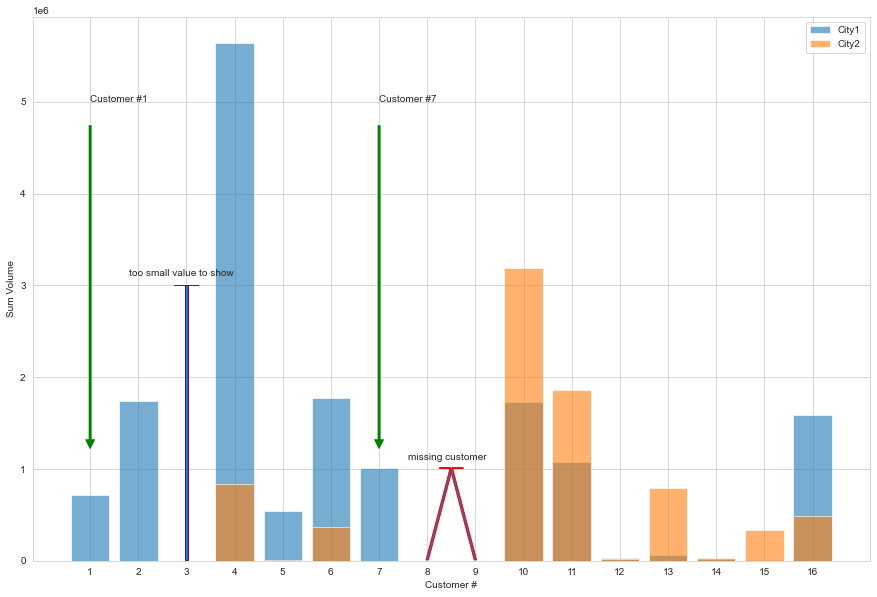

In [31]:

plt.figure(figsize= (15,10))
bar1 = plt.bar(gb_city_customer_df[gb_city_customer_df['City']== 'City1']['Customer'],
        gb_city_customer_df[gb_city_customer_df['City']== 'City1']['Volume'], 
               label = 'City1', alpha = 0.6)
bar2 = plt.bar(gb_city_customer_df[gb_city_customer_df['City']== 'City2']['Customer'],
        gb_city_customer_df[gb_city_customer_df['City']== 'City2']['Volume'], 
               label = 'City2', alpha = 0.6)
plt.annotate('Customer #7', xy =(7, 1000000),
                xytext =(7, 5000000), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05))
plt.annotate('Customer #1', xy =(1, 1000000),
                xytext =(1, 5000000), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05))
plt.legend()
plt.arrow(8, 10000,0.5,1000000,
          head_width = 0.5,
          width = 0.05,
          ec ='red')
plt.arrow(9, 10000,-0.5,1000000,
          head_width = 0.5,
          width = 0.05,
          ec ='red')
plt.text(7.6,1100000,'missing customer')
plt.arrow(3, 10000,0,3000000,
          head_width = 0.5,
          width = 0.05,
          ec ='purple')
plt.text(1.8,3100000,'too small value to show')
plt.xticks(np.arange(1,17,1))
plt.xlabel('Customer #')
plt.ylabel('Sum Volume')
plt.show()

## Trend Analysis

In [32]:
target_customer = ['Customer1','Customer2','Customer3','Customer4','Customer5',
                  'Customer6','Customer7']

In [33]:
df['MONTH'] = df['Date'].dt.strftime("%Y-%m")

In [34]:
df.head()

Customer   City       Date  Volume    MONTH
0  Customer15  City2 2021-12-22     402  2021-12
1  Customer11  City2 2022-09-03     140  2022-09
2  Customer16  City1 2022-03-04     913  2022-03
3  Customer10  City1 2020-06-16    2580  2020-06
4   Customer2  City2 2020-06-28       1  2020-06

In [35]:
df['YEAR'] = pd.DatetimeIndex(df['Date']).year

In [36]:
df.head()

Customer   City       Date  Volume    MONTH  YEAR
0  Customer15  City2 2021-12-22     402  2021-12  2021
1  Customer11  City2 2022-09-03     140  2022-09  2022
2  Customer16  City1 2022-03-04     913  2022-03  2022
3  Customer10  City1 2020-06-16    2580  2020-06  2020
4   Customer2  City2 2020-06-28       1  2020-06  2020

In [37]:
df['DAY_NAME'] = pd.DatetimeIndex(df['Date']).day_name()

In [38]:
df.head()

Customer   City       Date  Volume    MONTH  YEAR   DAY_NAME
0  Customer15  City2 2021-12-22     402  2021-12  2021  Wednesday
1  Customer11  City2 2022-09-03     140  2022-09  2022   Saturday
2  Customer16  City1 2022-03-04     913  2022-03  2022     Friday
3  Customer10  City1 2020-06-16    2580  2020-06  2020    Tuesday
4   Customer2  City2 2020-06-28       1  2020-06  2020     Sunday

### Yearly Trend

In [39]:
ann_trend = df.groupby(['Customer','City','YEAR']).agg(ann_vol_sum = pd.NamedAgg('Volume','sum'),
                                   ann_vol_mean = pd.NamedAgg('Volume','mean'),
                                   ann_vol_std = pd.NamedAgg('Volume','std'),
                                   ann_vol_var = pd.NamedAgg('Volume','var'),
                                   ann_vol_min = pd.NamedAgg('Volume','min'),
                                   ann_vol_max = pd.NamedAgg('Volume','max'),
                                   ann_vol_cnt = pd.NamedAgg('Volume','count'))

In [40]:
ann_trend.reset_index(inplace = True)

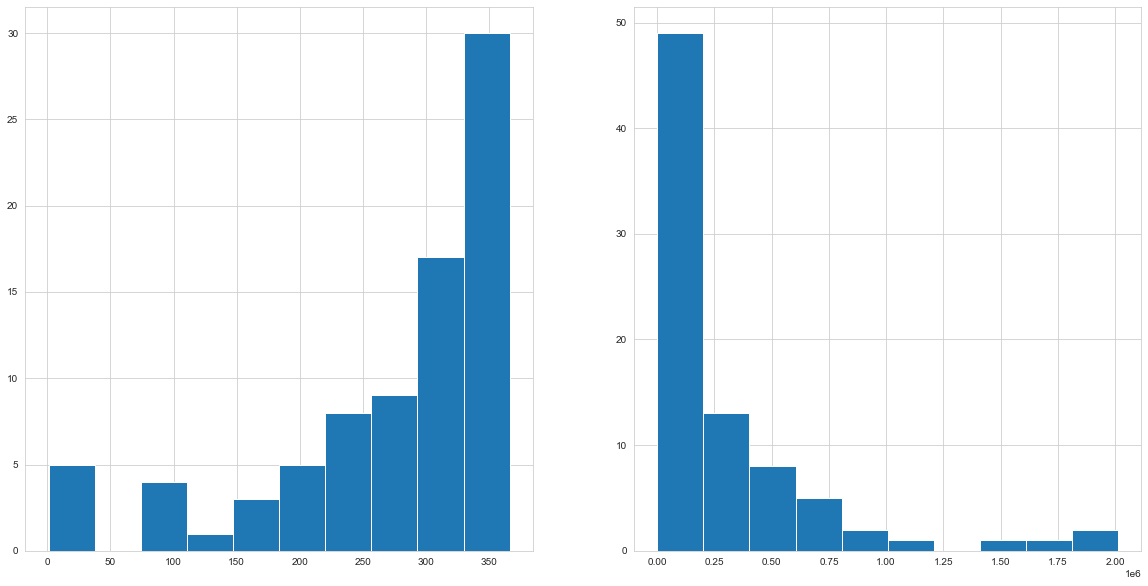

In [41]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.hist(ann_trend['ann_vol_cnt'])
plt.subplot(1,2,2)
plt.hist(ann_trend['ann_vol_sum'])
plt.show()


<AxesSubplot:xlabel='YEAR', ylabel='ann_vol_sum'>

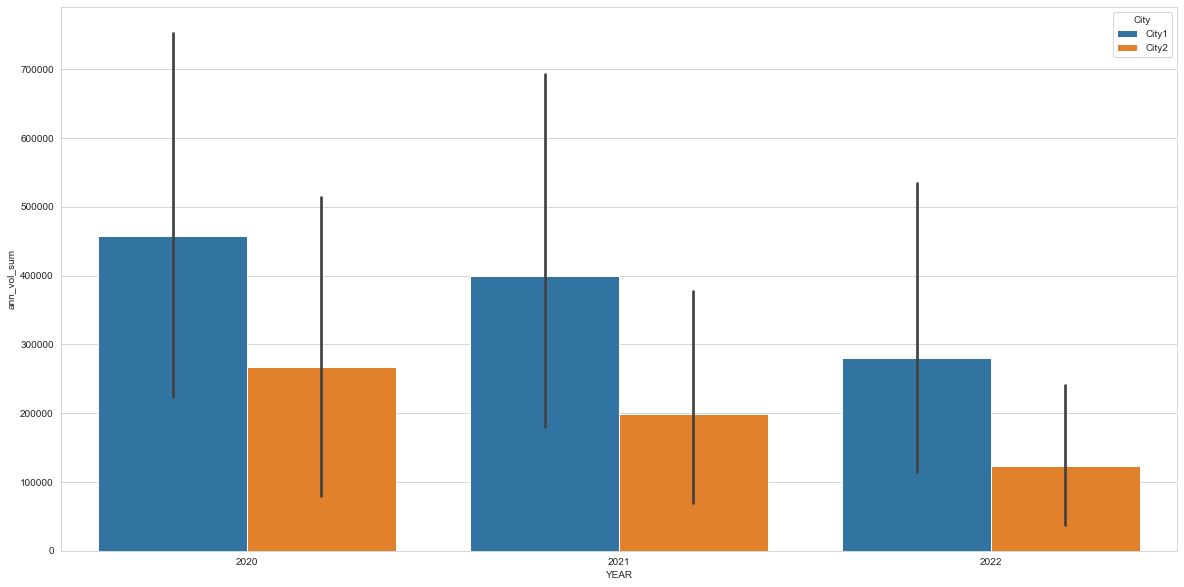

In [42]:
plt.figure(figsize = (20,10))
sns.barplot(y = 'ann_vol_sum' , x = 'YEAR' ,data = ann_trend, hue = 'City')

<AxesSubplot:xlabel='YEAR', ylabel='ann_vol_sum'>

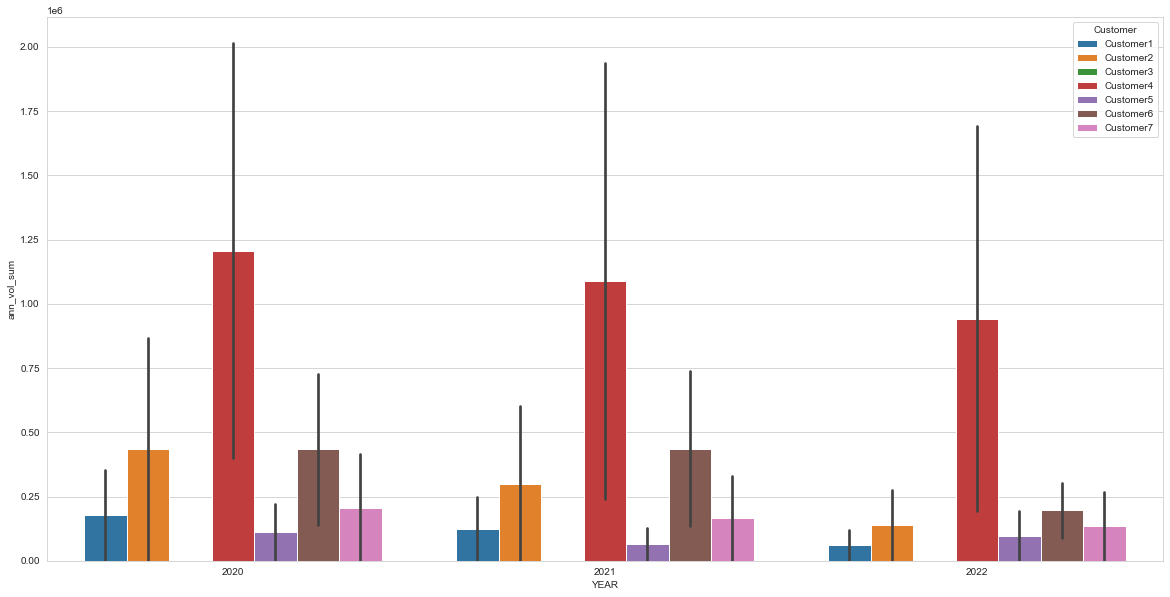

In [43]:
plt.figure(figsize=(20,10))
sns.barplot(y = 'ann_vol_sum' , x = 'YEAR' ,data = ann_trend[ann_trend.Customer.isin(target_customer)], hue = 'Customer')

### Monthly Trend

In [45]:
mth_trend = df.groupby(['Customer','City','MONTH']).agg(mth_vol_sum = pd.NamedAgg('Volume','sum'),
                                   mth_vol_mean = pd.NamedAgg('Volume','mean'),
                                   mth_vol_std = pd.NamedAgg('Volume','std'),
                                   mth_vol_var = pd.NamedAgg('Volume','var'),
                                   mth_vol_min = pd.NamedAgg('Volume','min'),
                                   mth_vol_max = pd.NamedAgg('Volume','max'),
                                   mth_vol_cnt = pd.NamedAgg('Volume','count'))

In [46]:
mth_trend.reset_index(inplace=True)

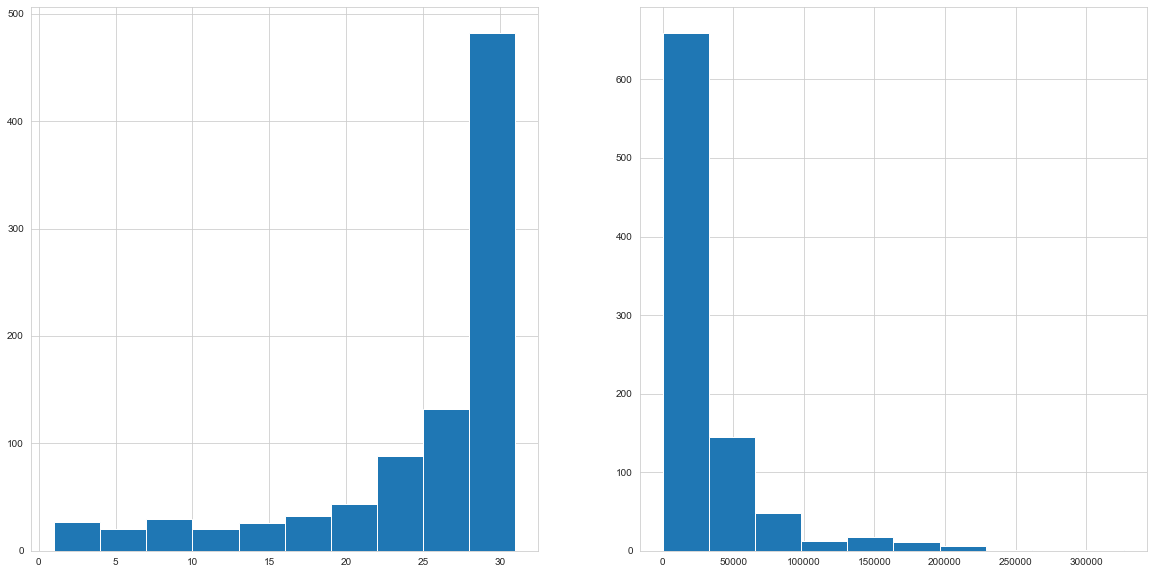

In [47]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.hist(mth_trend['mth_vol_cnt'])
plt.subplot(1,2,2)
plt.hist(mth_trend['mth_vol_sum'])
plt.show()

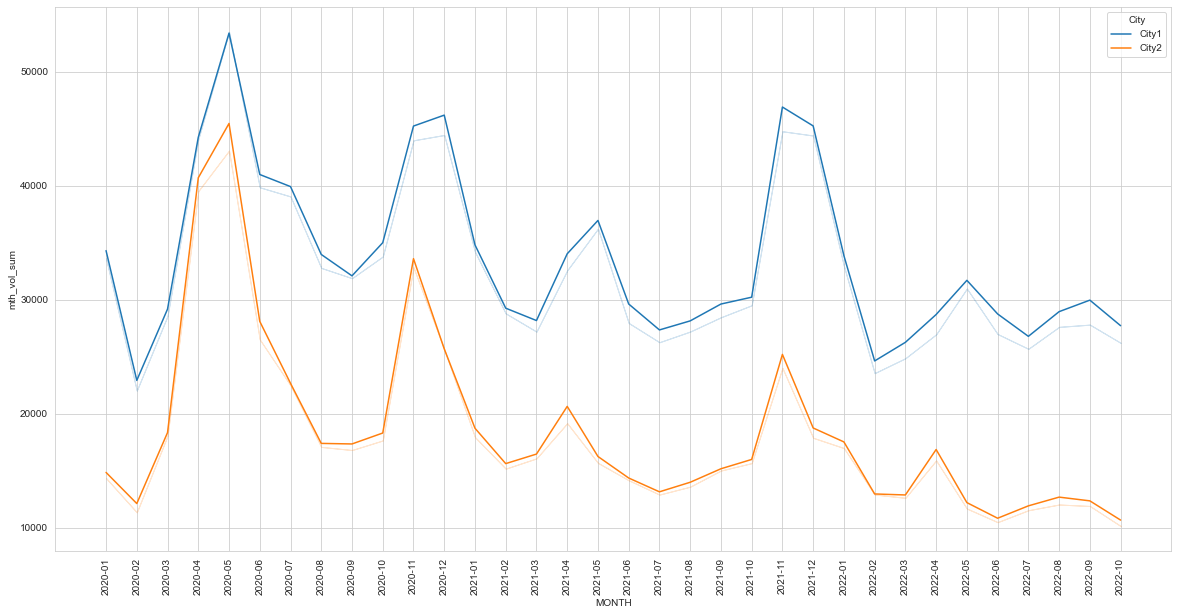

In [49]:
plt.figure(figsize = (20,10))
sns.lineplot(y = 'mth_vol_sum' , x = 'MONTH' ,data = mth_trend, hue = 'City',ci=False)
plt.xticks(rotation = 90)
plt.show()

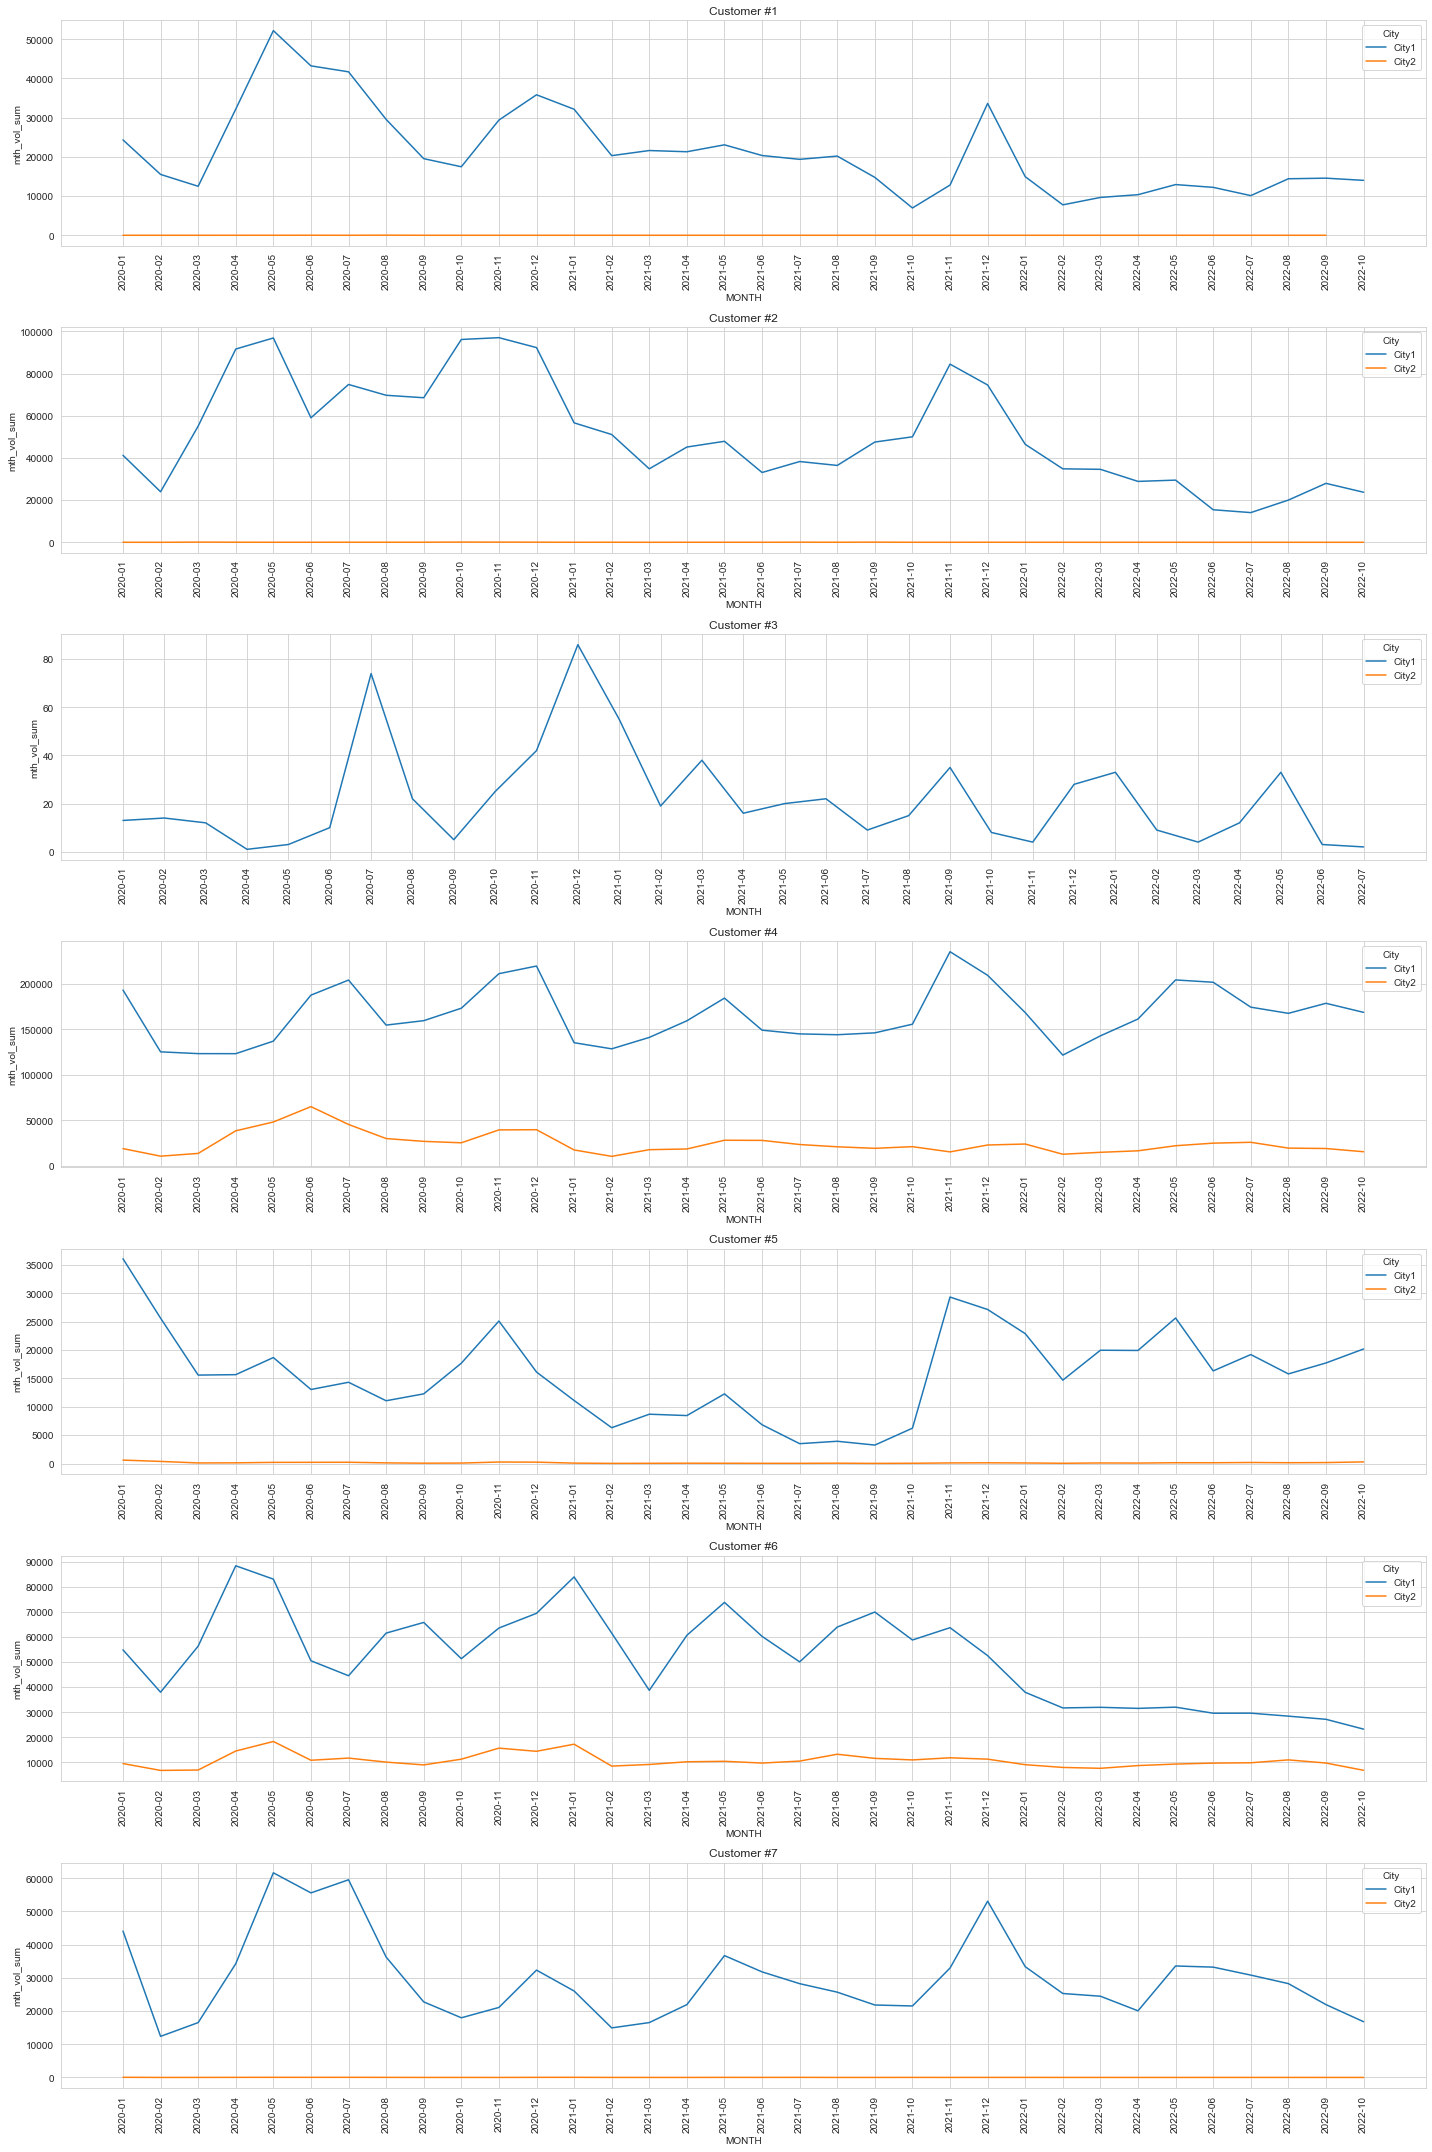

In [50]:
plt.figure(figsize=(20,30))
for index,customer in enumerate(target_customer):
    plt.subplot(7,1,index+1)
    sns.lineplot(y = 'mth_vol_sum' , x = 'MONTH' ,data = mth_trend[mth_trend.Customer == customer],
                hue = 'City',ci=False)
    plt.title('Customer #{}'.format(index+1))
    plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Weekday Trend

In [51]:
weekday_trend = df.groupby(['Customer','City','DAY_NAME']).agg(weekday_vol_sum = pd.NamedAgg('Volume','sum'),
                                   weekday_vol_mean = pd.NamedAgg('Volume','mean'),
                                   weekday_vol_std = pd.NamedAgg('Volume','std'),
                                   weekday_vol_var = pd.NamedAgg('Volume','var'),
                                   weekday_vol_min = pd.NamedAgg('Volume','min'),
                                   weekday_vol_max = pd.NamedAgg('Volume','max'),
                                   weekday_vol_cnt = pd.NamedAgg('Volume','count'))

In [52]:
weekday_trend.reset_index(inplace=True)

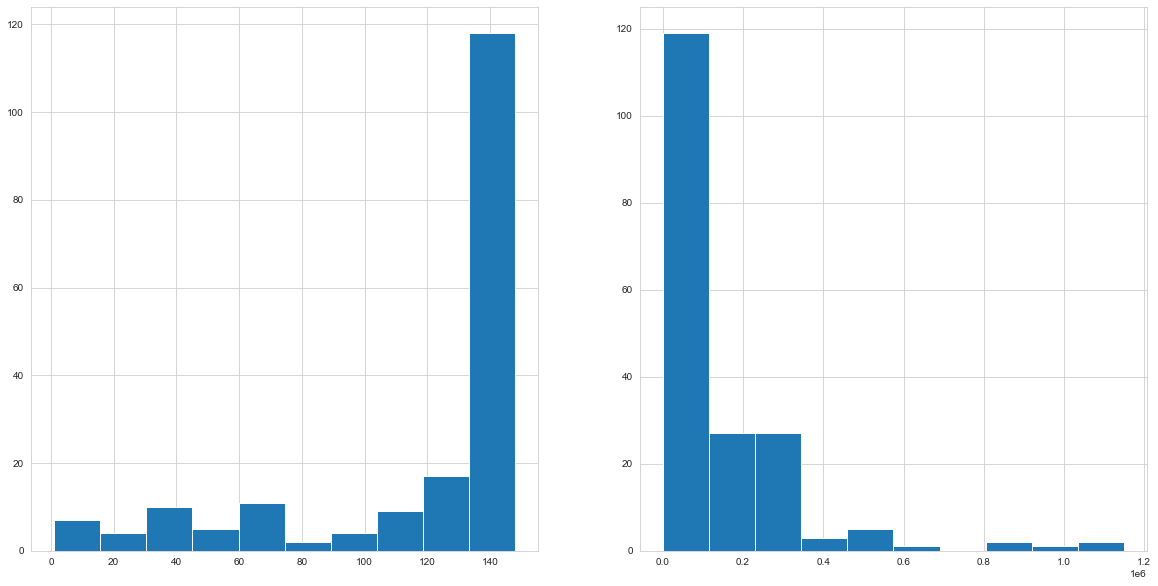

In [53]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.hist(weekday_trend['weekday_vol_cnt'])
plt.subplot(1,2,2)
plt.hist(weekday_trend['weekday_vol_sum'])
plt.show()

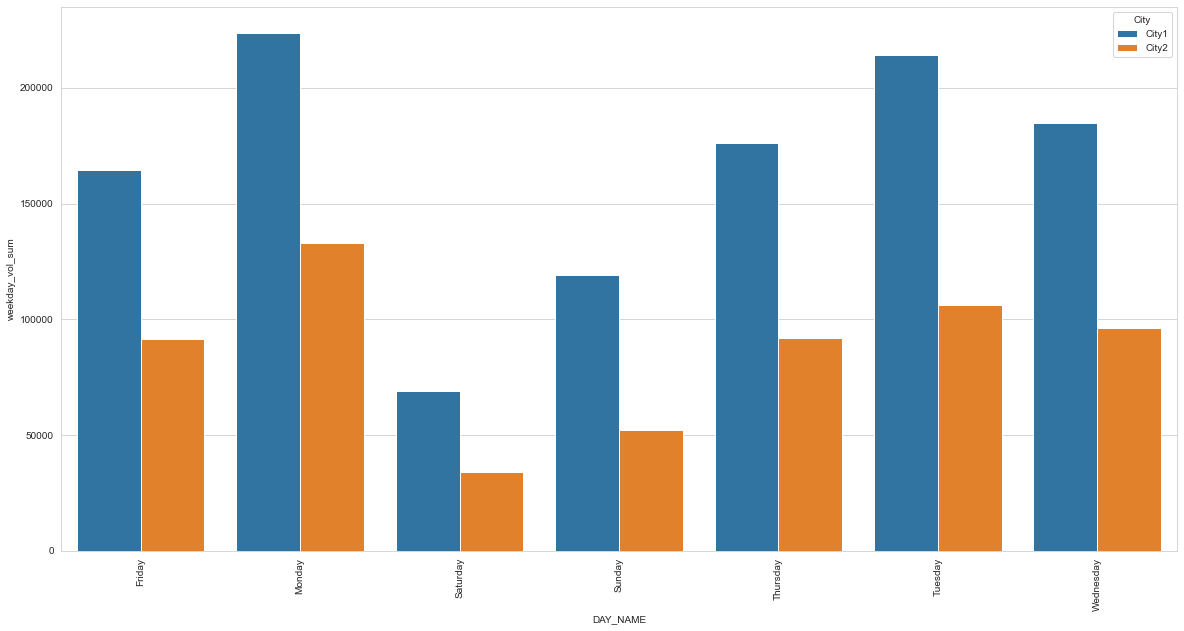

In [54]:
plt.figure(figsize = (20,10))
sns.barplot(y = 'weekday_vol_sum' , x = 'DAY_NAME' ,data = weekday_trend, hue = 'City',ci=False)
plt.xticks(rotation = 90)
plt.show()

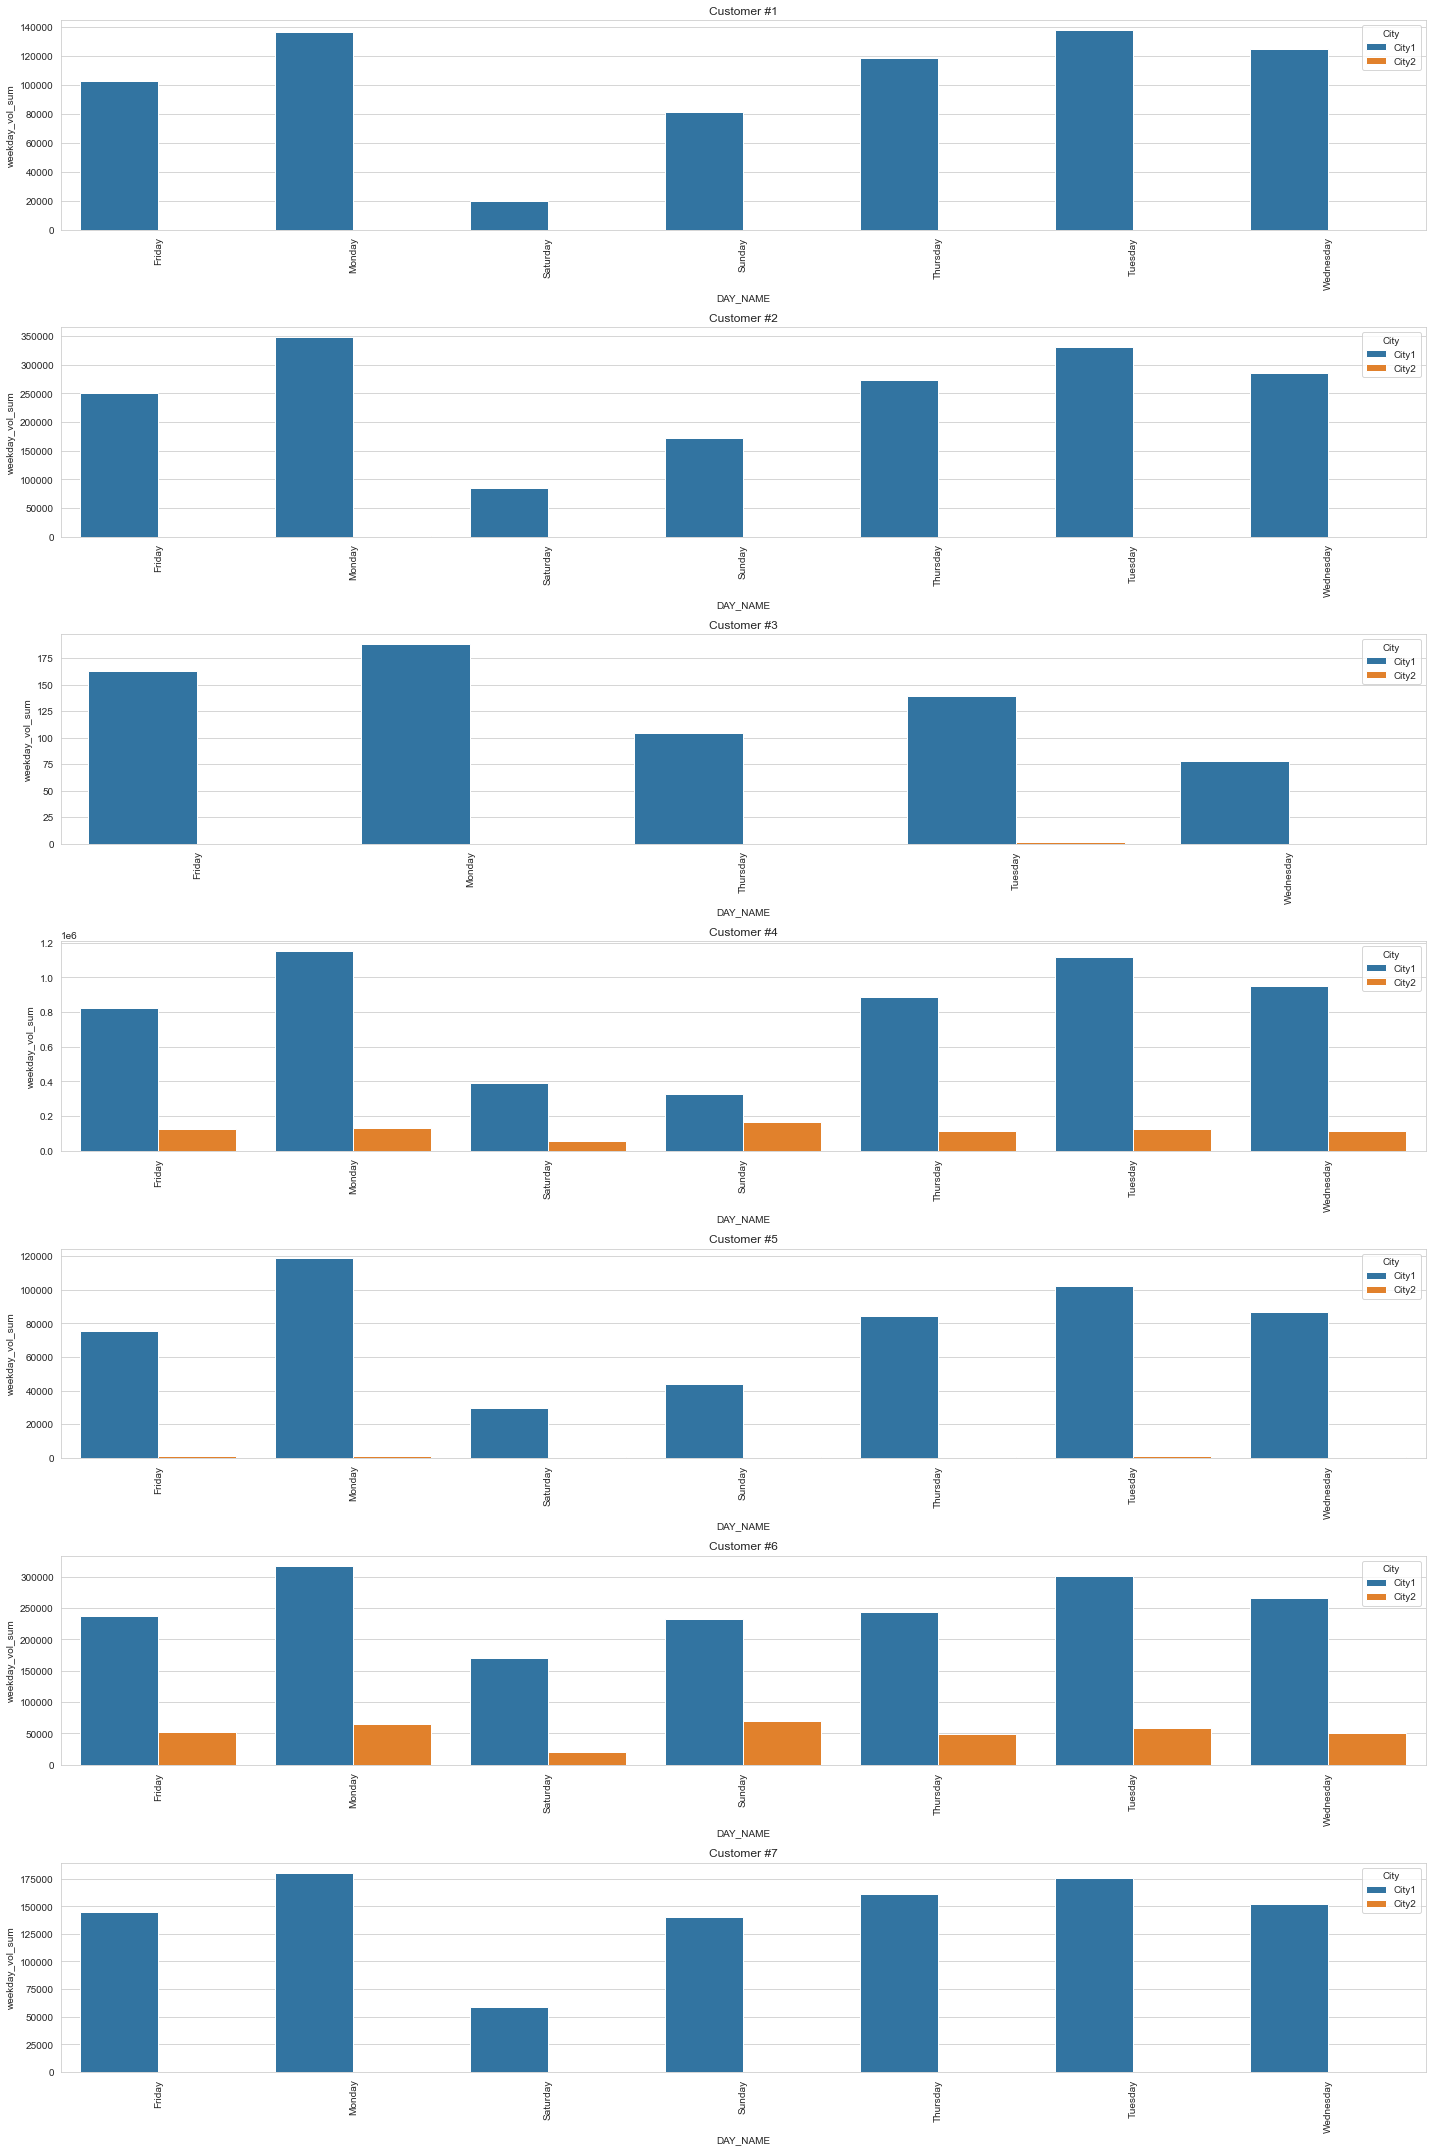

In [55]:
plt.figure(figsize=(20,30))
for index,customer in enumerate(target_customer):
    plt.subplot(7,1,index+1)
    sns.barplot(y = 'weekday_vol_sum' , x = 'DAY_NAME' ,data = weekday_trend[weekday_trend.Customer == customer],
                hue = 'City',ci=False)
    plt.title('Customer #{}'.format(index+1))
    plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

# Model Implementing

## Prophet

In [84]:
covid_waves = pd.DataFrame([
    {'holiday': 'wave1', 'ds': '2020-04-01', 'lower_window': 0, 'ds_upper': '2020-06-30'},
    {'holiday': 'wave2', 'ds': '2021-04-01', 'lower_window': 0, 'ds_upper': '2021-06-15'}])
for t_col in ['ds', 'ds_upper']:
    covid_waves[t_col] = pd.to_datetime(covid_waves[t_col])
covid_waves['upper_window'] = (covid_waves['ds_upper'] - covid_waves['ds']).dt.days

In [85]:
covid_waves

holiday         ds  lower_window   ds_upper  upper_window
0   wave1 2020-04-01             0 2020-06-30            90
1   wave2 2021-04-01             0 2021-06-15            75

In [120]:
def prophet_model(ts_data,target_customer_list,test_date_y,test_date_m,test_date_d,holiday_effect = True,city = 'City1' ):
    """
    ts_data: time series data
    :param ts_data:
    :param target_customer_list:
    :param test_date_y:
    :param test_date_m:
    :param test_date_d:
    :param trend_interval:
    :param holiday_effect:
    :param city:
    :return:
    """
    processed_df = ts_data[(ts_data.City == city)& (ts_data.Customer.isin(target_customer_list))]
    processed_df = processed_df.groupby(['Date']).agg(Volume = pd.NamedAgg('Volume','sum')).reset_index()
    processed_df = processed_df.rename({'Date':'ds','Volume':'y'},axis = 1)
    period = (ts_data['Date'].max()-dt.datetime(test_date_y,test_date_m,test_date_d)).days
    covid_waves = pd.DataFrame([
    {'holiday': 'wave1', 'ds': '2020-04-01', 'lower_window': 0, 'ds_upper': '2020-06-30'},
    {'holiday': 'wave2', 'ds': '2021-04-01', 'lower_window': 0, 'ds_upper': '2021-06-15'}])
    for t_col in ['ds', 'ds_upper']:
        covid_waves[t_col] = pd.to_datetime(covid_waves[t_col])
    covid_waves['upper_window'] = (covid_waves['ds_upper'] - covid_waves['ds']).dt.days
    if holiday_effect:
        model = Prophet(holidays = covid_waves,yearly_seasonality = True,weekly_seasonality = True,daily_seasonality = True)
    else:
        model = Prophet(yearly_seasonality = True,weekly_seasonality = True,daily_seasonality = True)
    model.fit(processed_df[processed_df.ds<dt.datetime(test_date_y,test_date_m,test_date_d)])
    future = model.make_future_dataframe(periods = period)
    forecast = model.predict(future)
    model.plot(forecast,figsize = (20,10))
    plt.show()
    plt.figure(figsize = (20,10))
    sns.lineplot(x = 'ds', y = 'y', data = processed_df[processed_df.ds>=dt.datetime(test_date_y,test_date_m,test_date_d)],
                 ci=False,label = 'True')
    sns.lineplot(x = 'ds', y = 'yhat', data = forecast[forecast.ds>=dt.datetime(test_date_y,test_date_m,test_date_d)],
                 label = 'Predicted')
    plt.xticks(rotation = 90)
    if len(target_customer_list) == 7:
        plt.title('Prediction VS. True for all target customers')
    else:
        plt.title('Prediction VS. True for target  {}'.format(target_customer_list))
    plt.legend()
    plt.show()

### Treating the COVID Waves as Holidays off

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


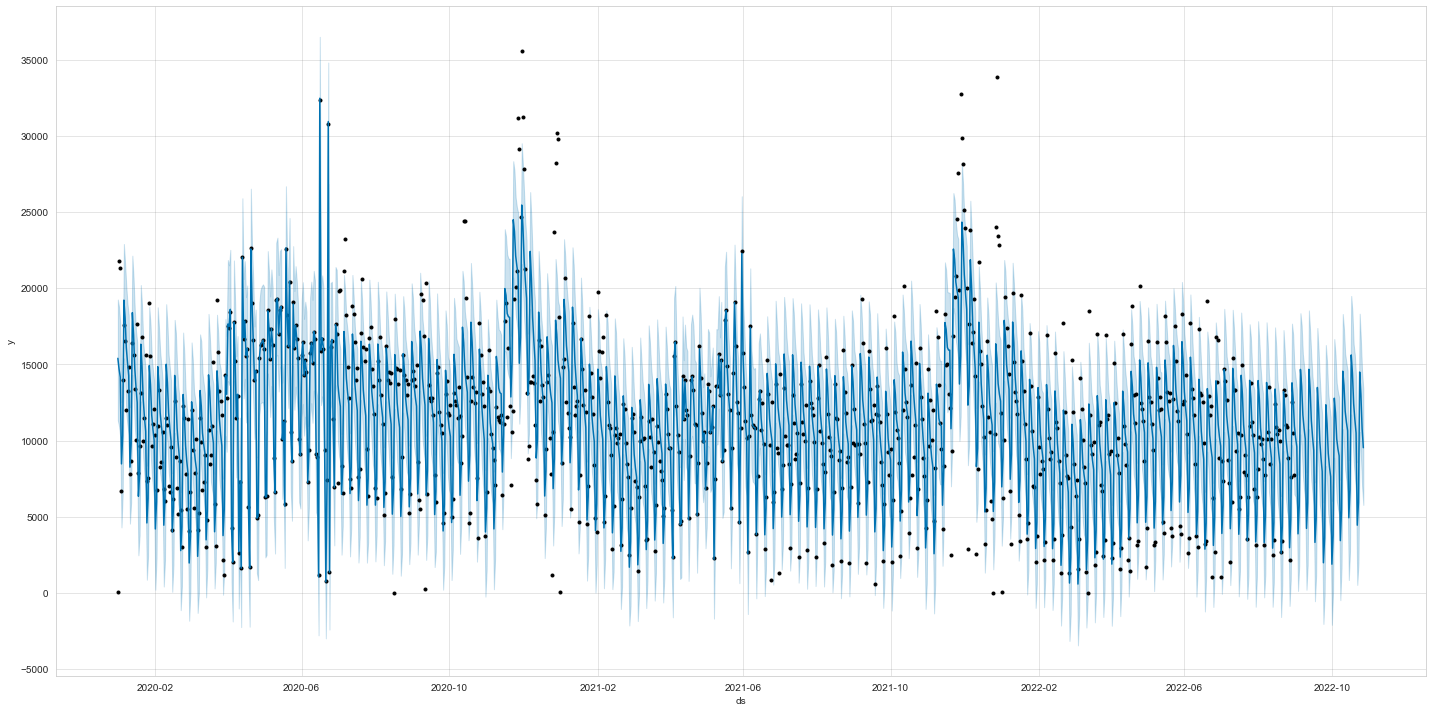

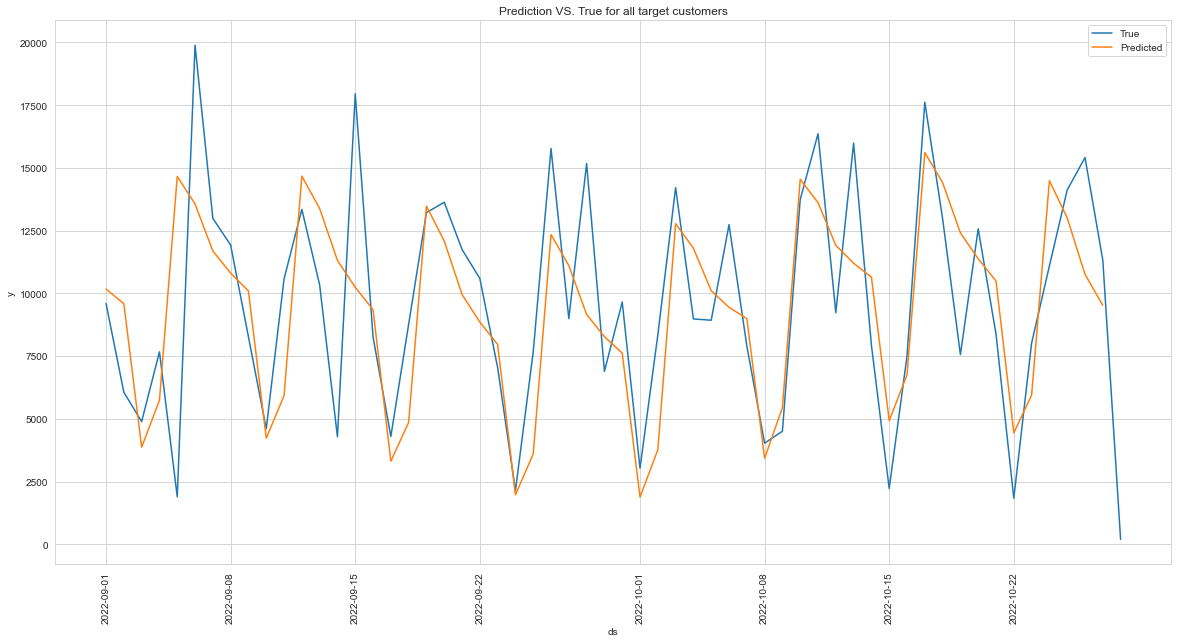

In [121]:
prophet_model(df,target_customer,2022,9,1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


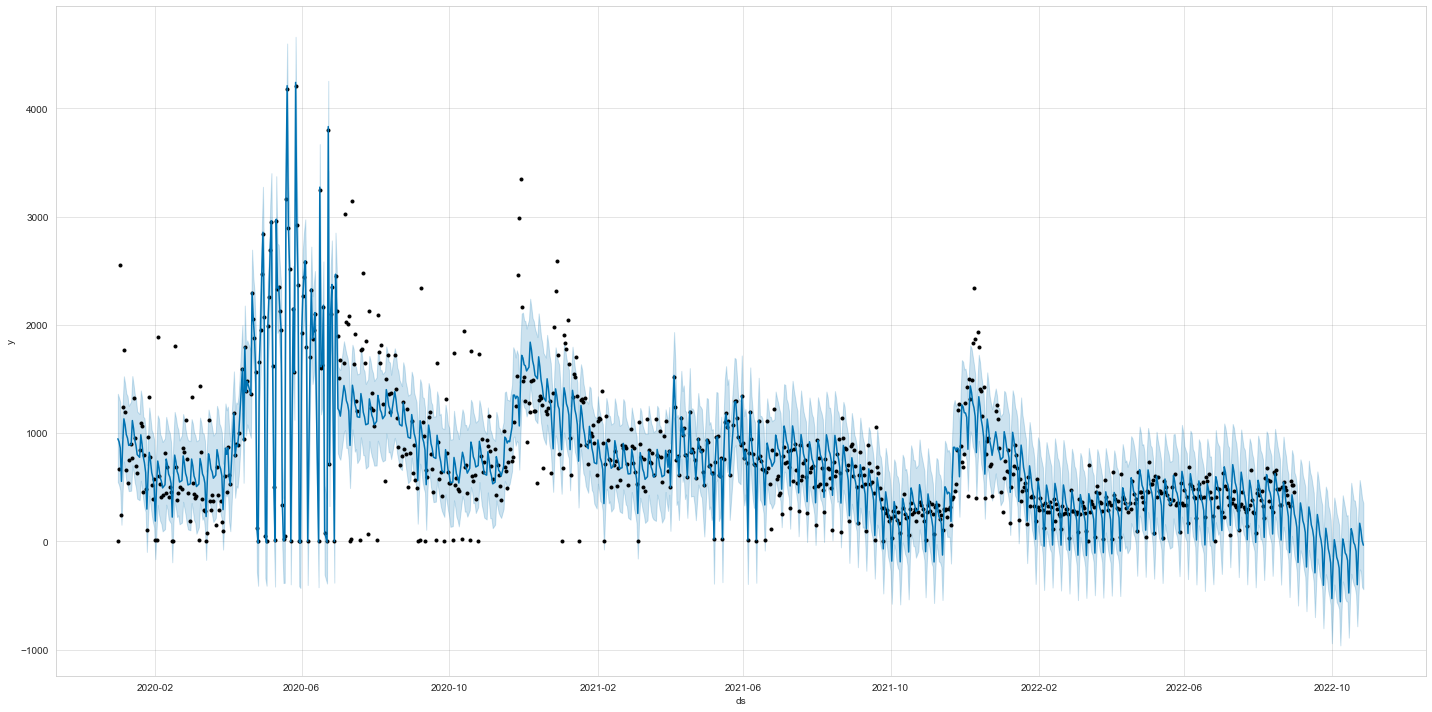

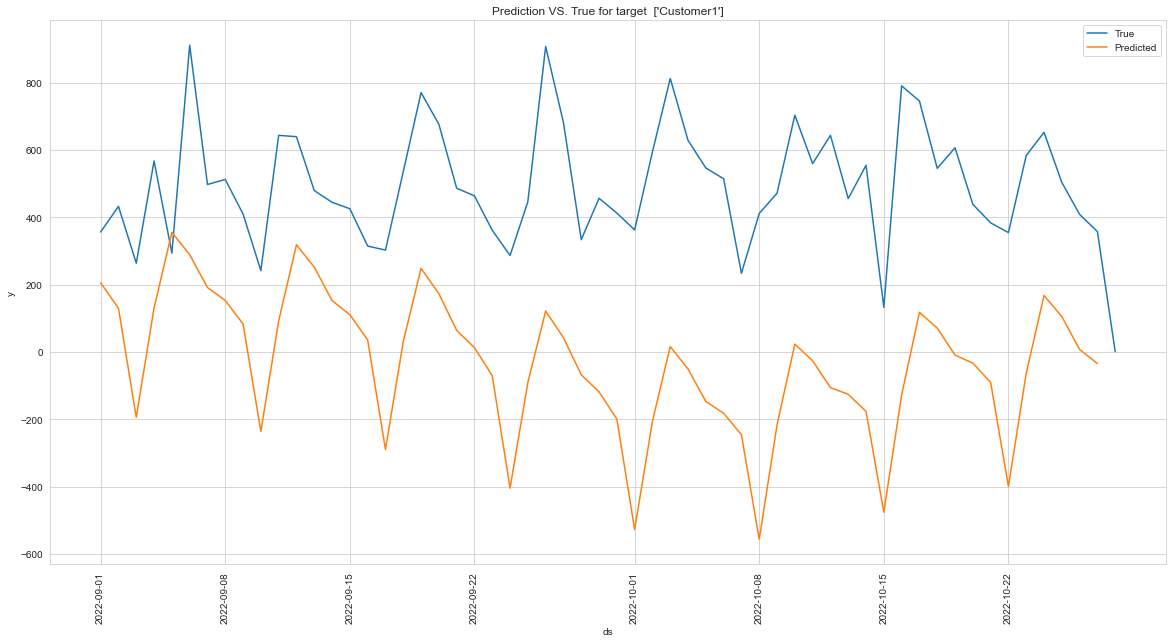

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


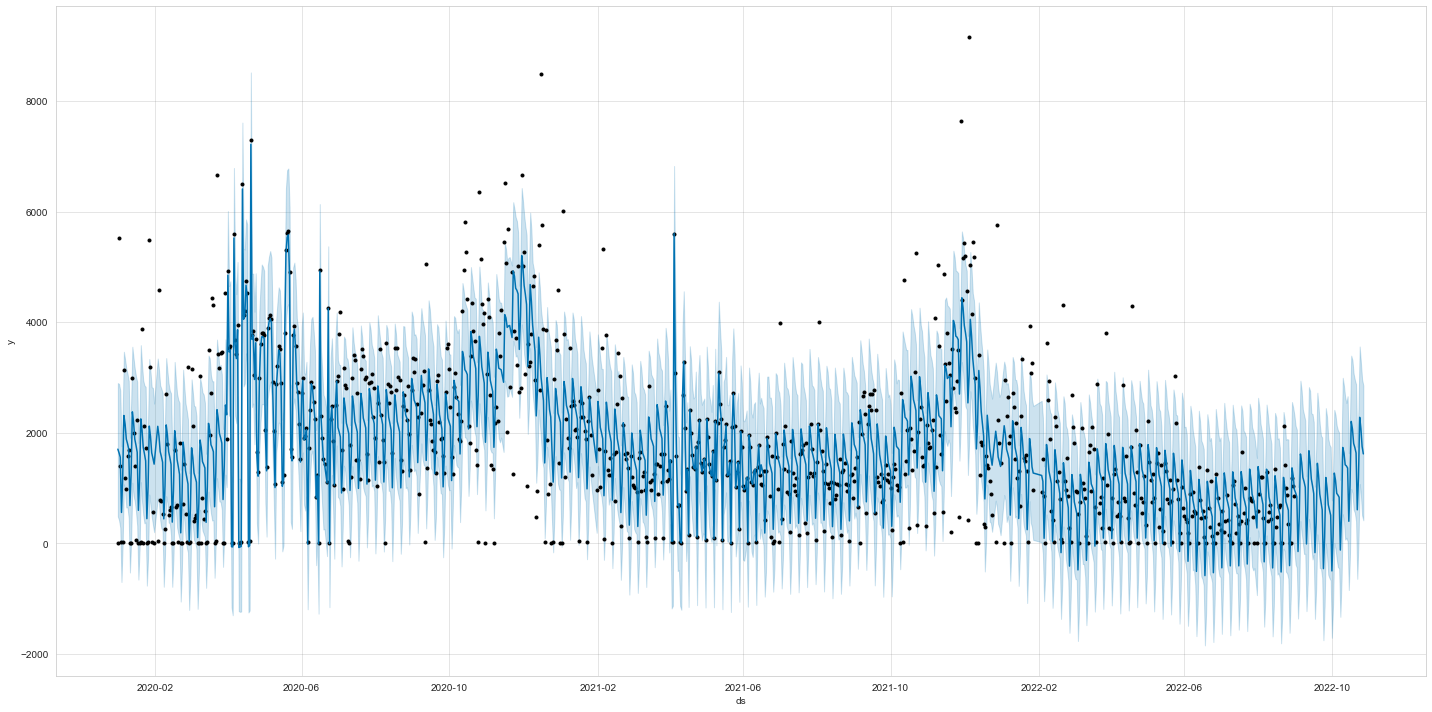

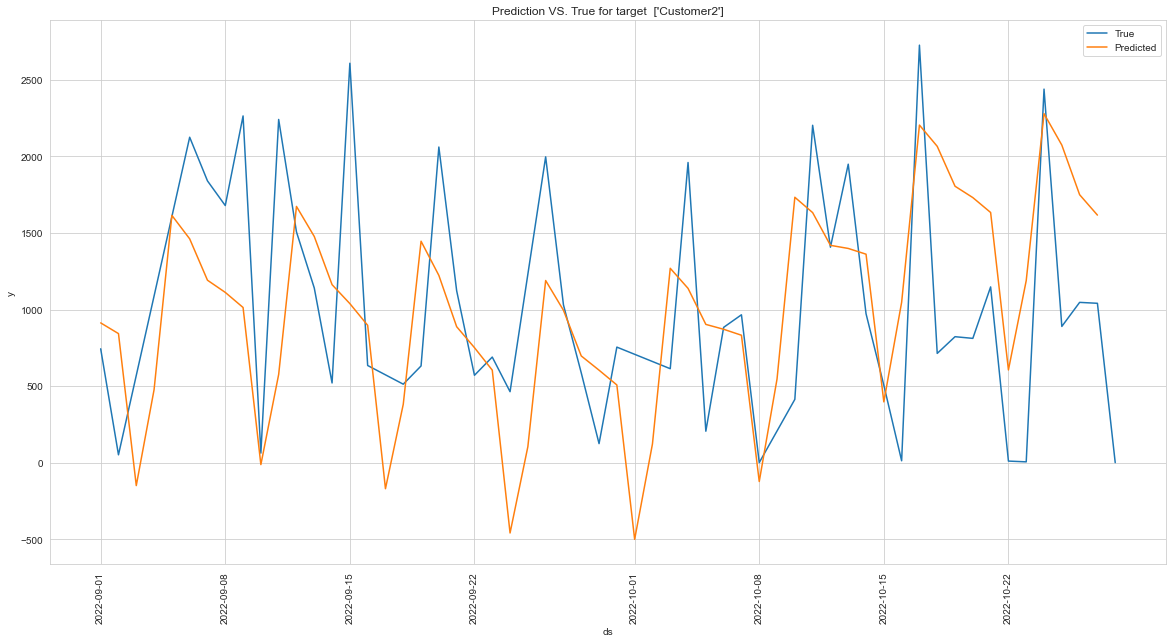

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


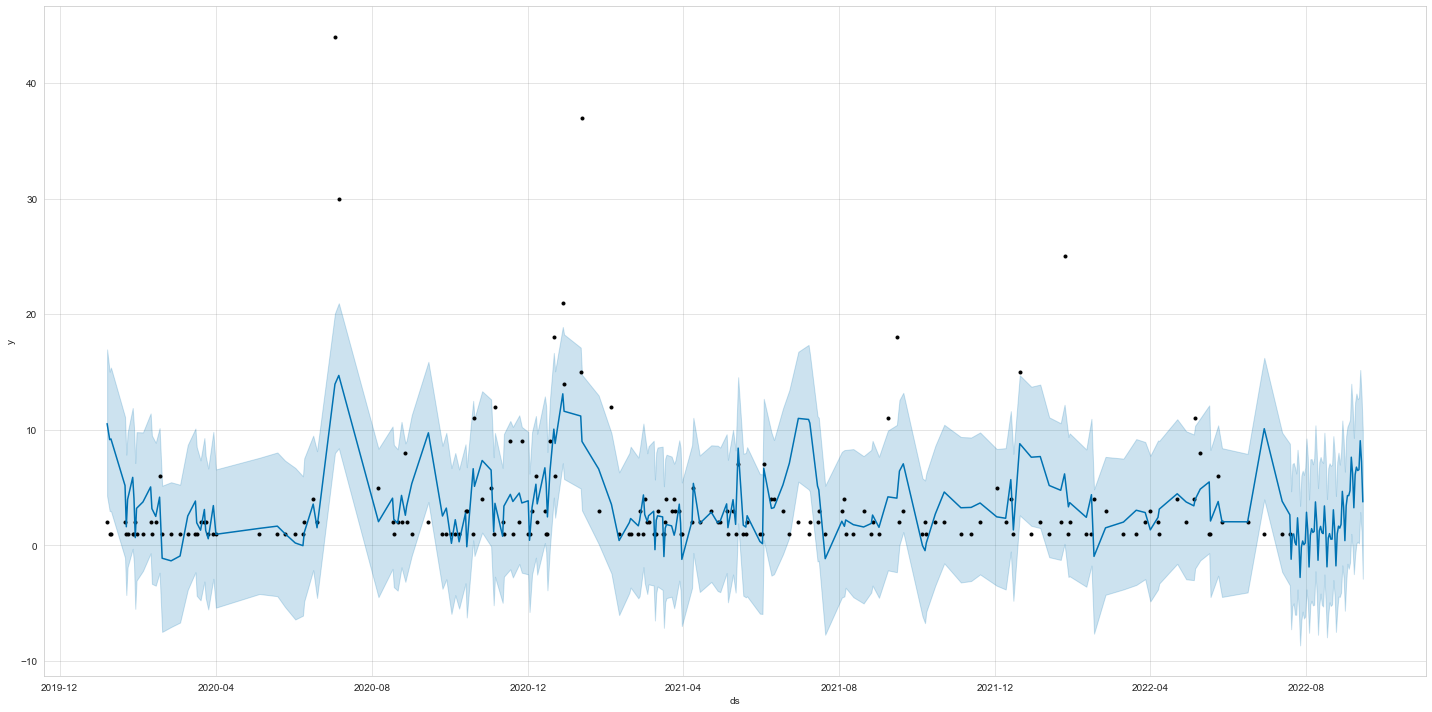

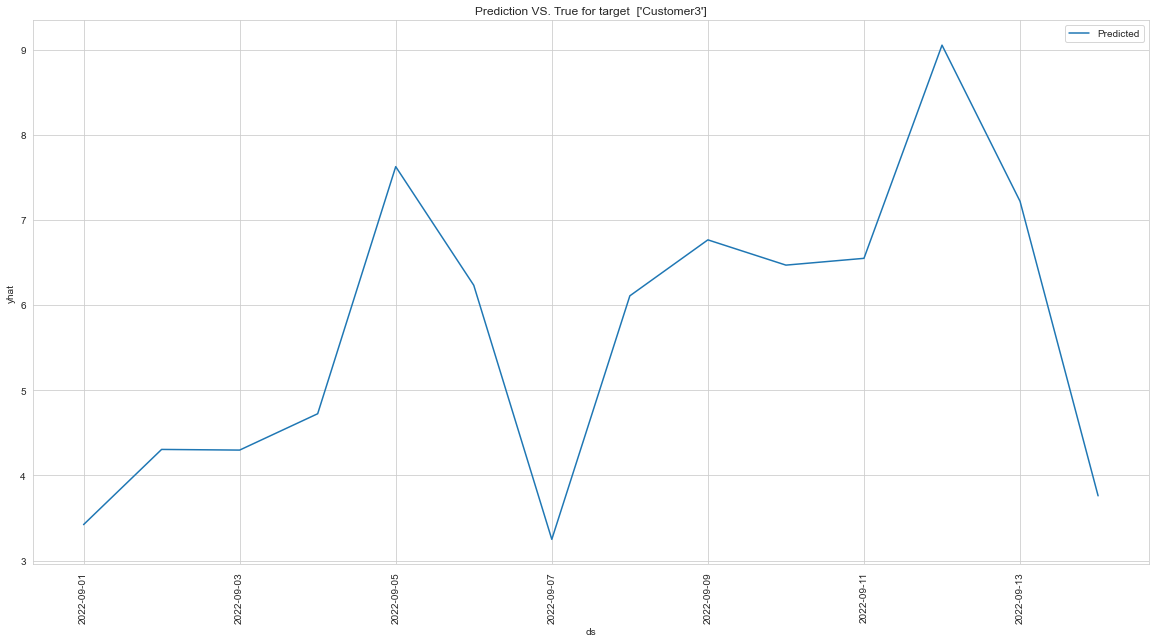

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


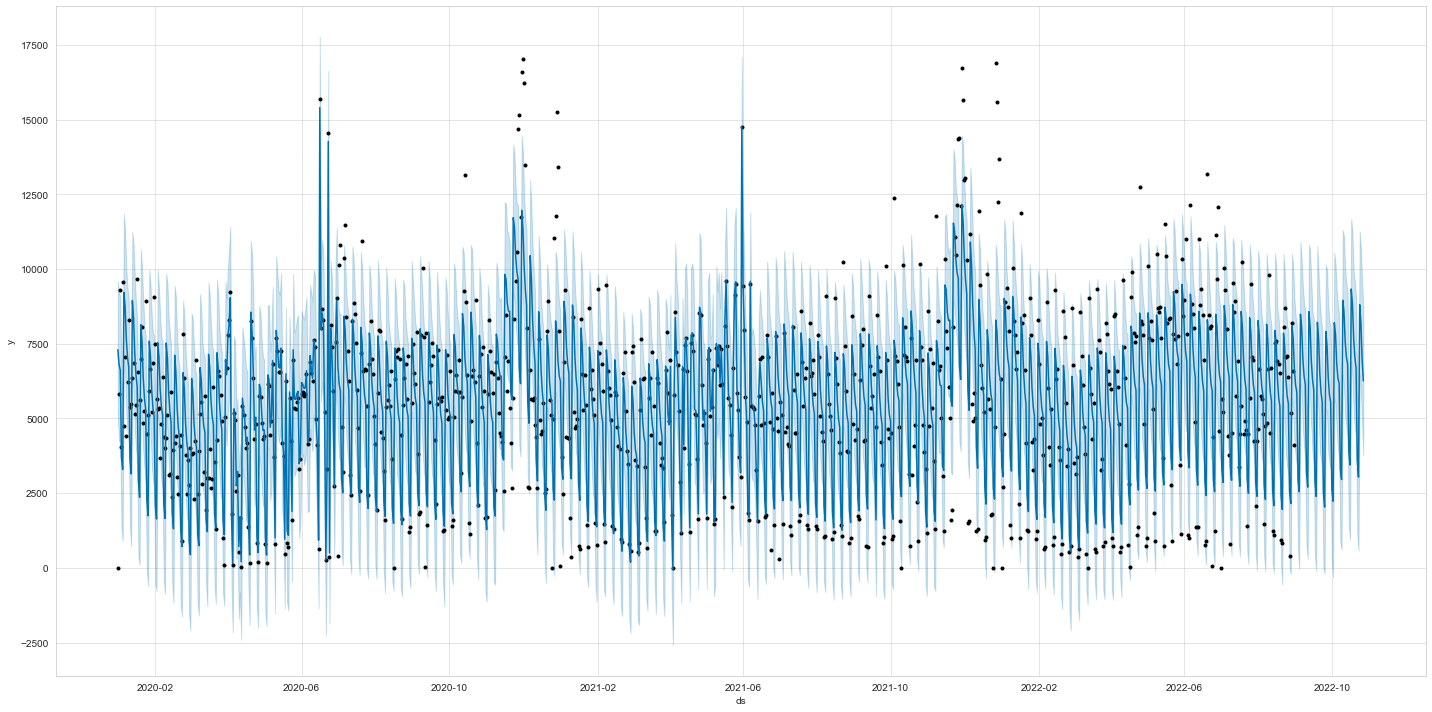

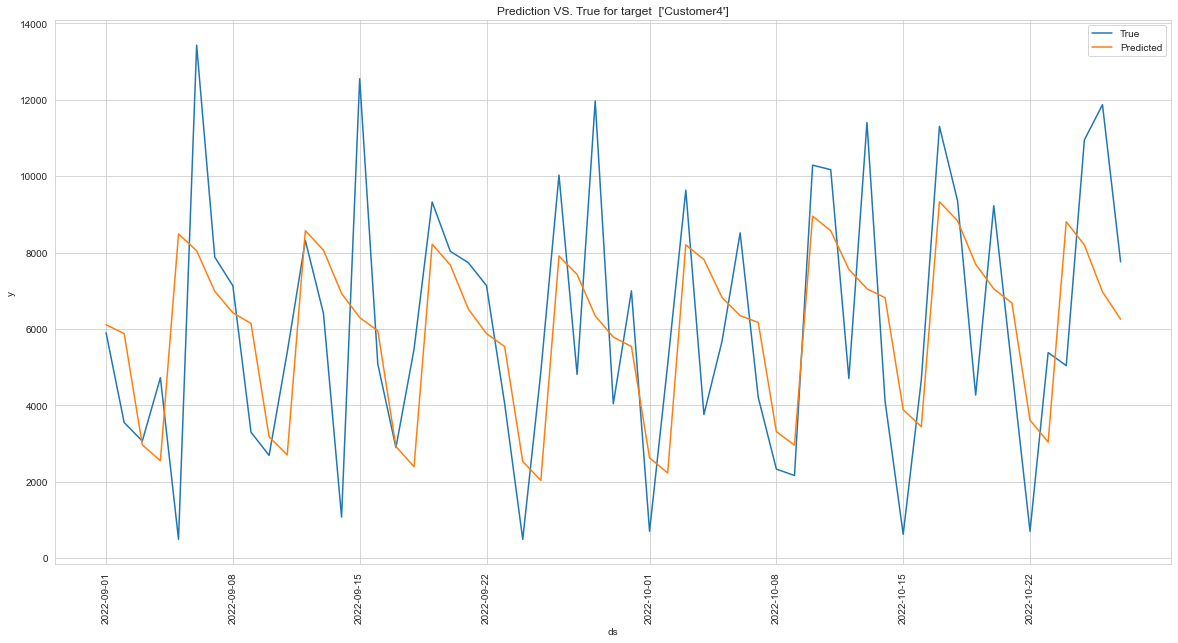

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


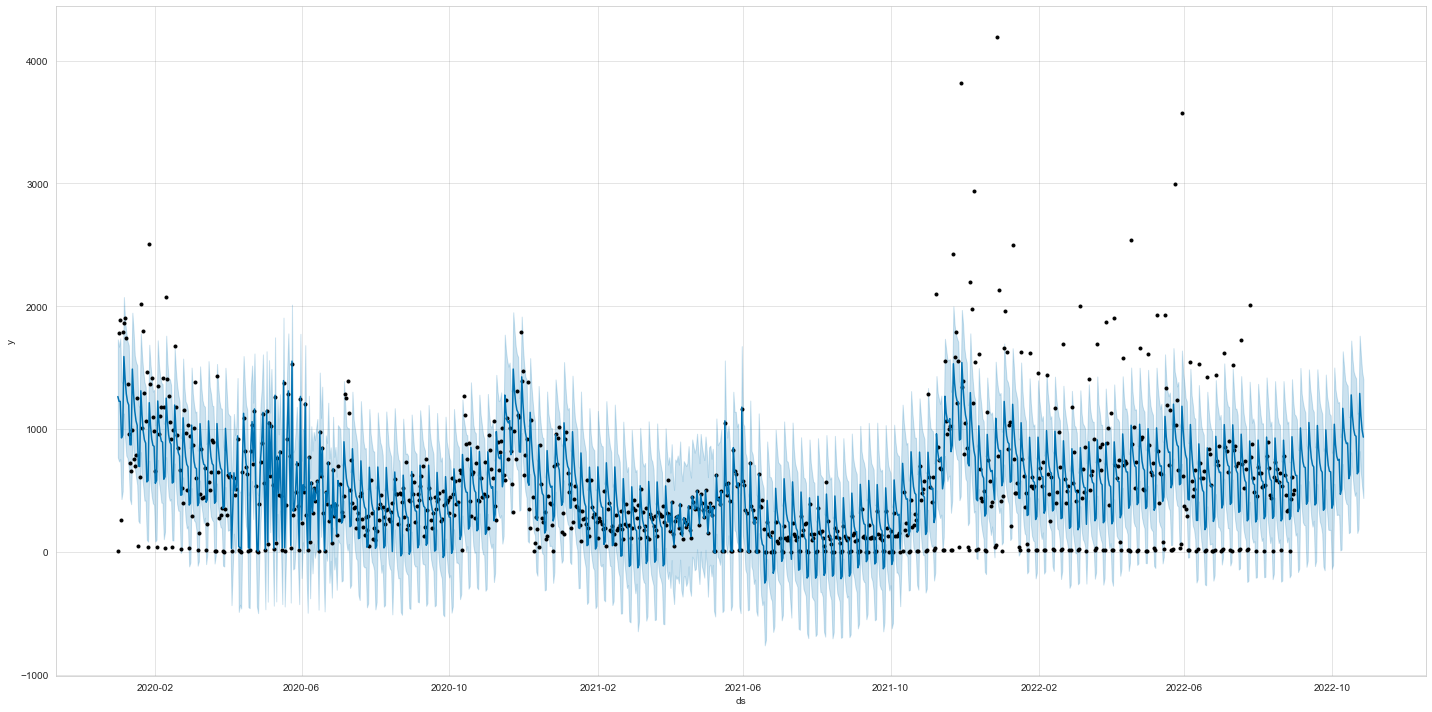

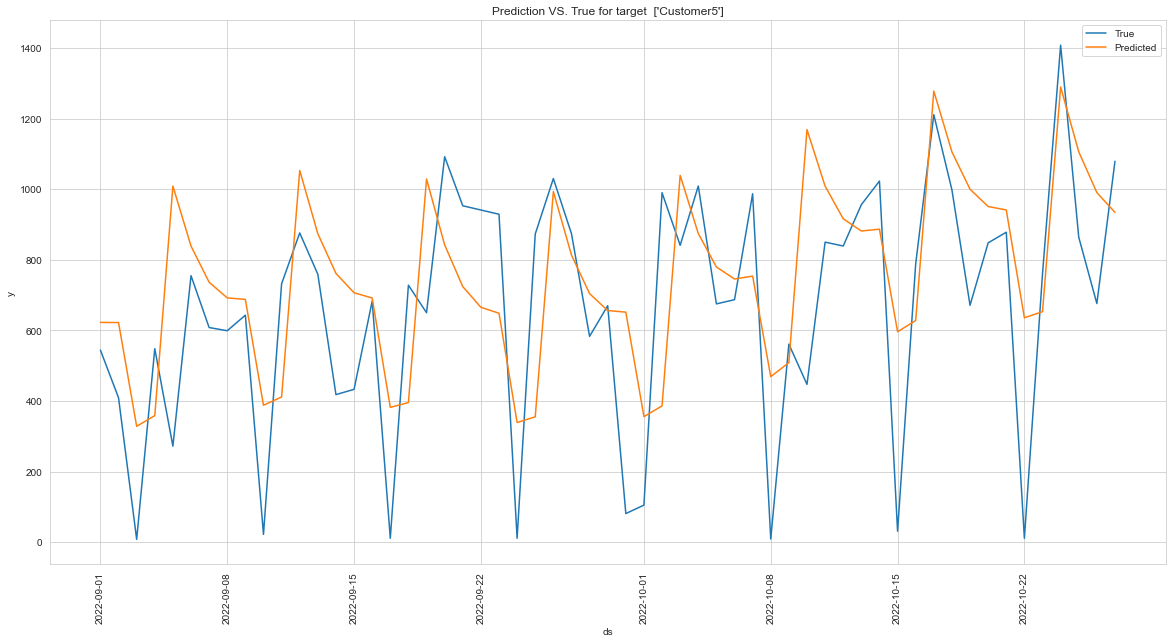

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


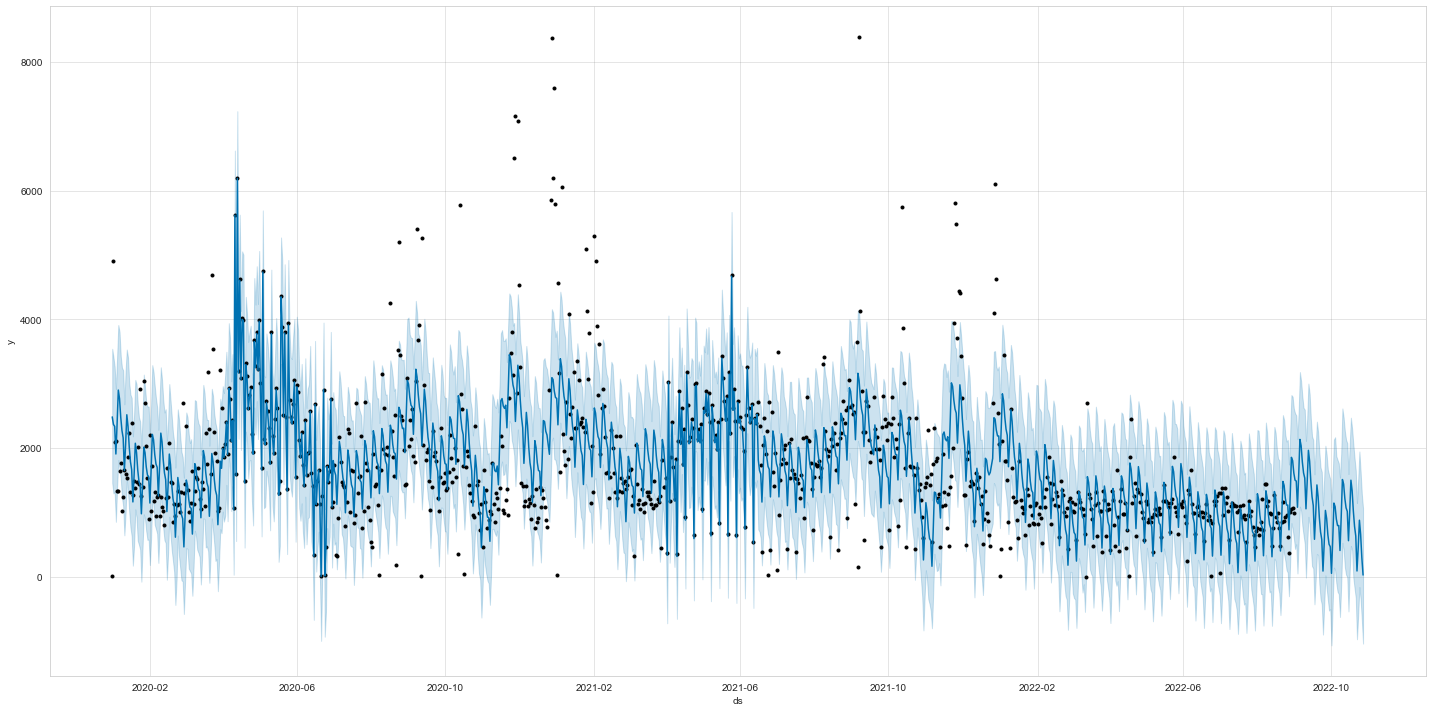

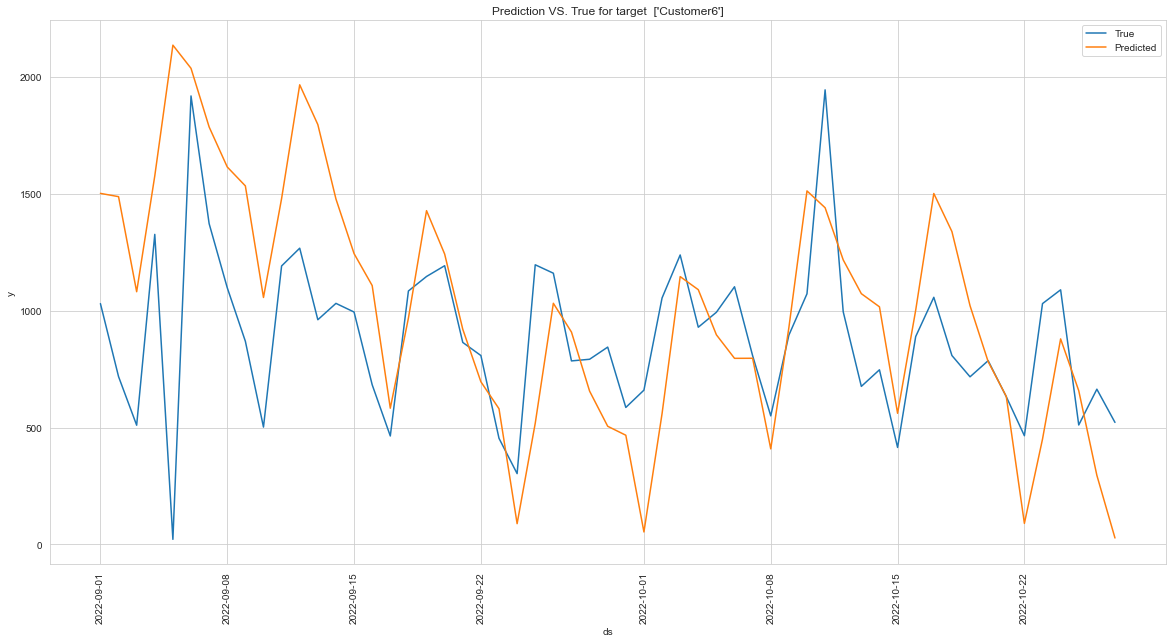

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


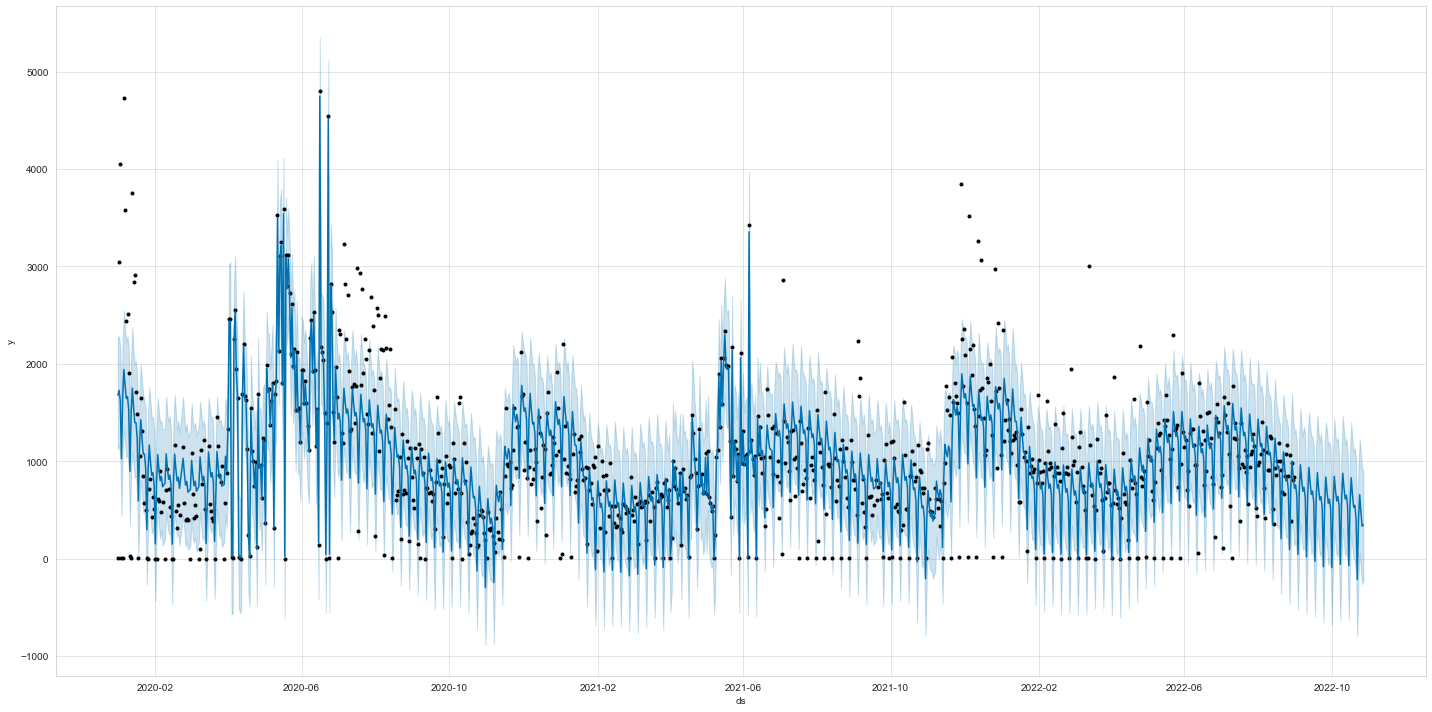

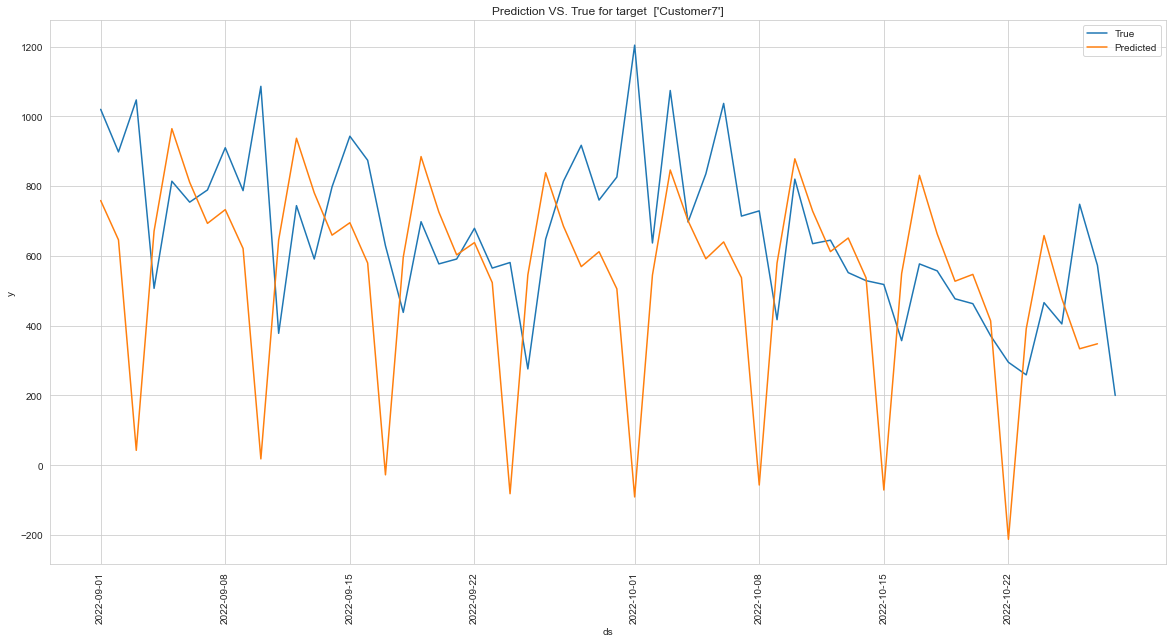

In [122]:
for customer in target_customer:
   prophet_model(df,[customer],2022,9,1)

## ARIMA

In [133]:
processed_df = df[(df.City == 'City1') & (df.Customer.isin(target_customer))].groupby(['Date']).agg(Volume = pd.NamedAgg('Volume','sum')).reset_index()

In [134]:
processed_df

Date  Volume
0    2020-01-01      34
1    2020-01-02   21761
2    2020-01-03   21303
3    2020-01-04    6673
4    2020-01-05   13953
...         ...     ...
1027 2022-10-24   11096
1028 2022-10-25   14121
1029 2022-10-26   15414
1030 2022-10-27   11331
1031 2022-10-28     202

[1032 rows x 2 columns]

In [136]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(processed_df.Volume)

(0.01, False)

In [127]:
def arima_model(df,train_test_date,target_customer_list,city = 'City1'):
    """
    
    :param df:
    :param train_test_date:
    :param target_customer_list:
    :param city:
    :return:
    """
    processed_df = df[(df.City == 'City1') & (df.Customer.isin(target_customer))].groupby(['Date']).agg(Volume = pd.NamedAgg('Volume','sum')).reset_index()
    sns.lineplot(x = 'Date', y = 'Volume', data = processed_df,ci=False)
    plt.show()



# Summary

# Business Recommendations